In [1]:
import time
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from data_process import data_process
from XGBoostClassifier import XGBoostClassifier
from RFClassifier import RFClassifier
from LSTMClassifier import SensorDataset, LSTMModel, LSTMClassifierWrapper
import seaborn as sns 
import pandas as pd
import xgboost as xgb
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(xgb.__version__)
print(sklearn.__version__)

Using device: cuda
2.4.1
11.8
90100
2.1.3
1.5.2


## LSTM算法实验

1. 根据路径读取数据，做数据预处理并检查种类数

In [5]:
path = "../harth/*.csv"  # 更新为实际路径
data = data_process(path)
print(set(data["label"]))

文件: ../harth\S006.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth\S006.csv, 时间范围: ('2019-01-12 00:00:00', '2019-01-12 01:09:32')
原始数据标签: {1, 130, 3, 4, 5, 6, 7, 8, 13, 14}
新的数据标签: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
<bound method DataFrame.info of                      timestamp    back_x    back_y    back_z   thigh_x  \
0      2019-01-12 00:00:00.000 -0.760242  0.299570  0.468570 -5.092732   
1      2019-01-12 00:00:00.010 -0.530138  0.281880  0.319987  0.900547   
2      2019-01-12 00:00:00.020 -1.170922  0.186353 -0.167010 -0.035442   
3      2019-01-12 00:00:00.030 -0.648772  0.016579 -0.054284 -1.554248   
4      2019-01-12 00:00:00.040 -0.355071 -0.051831 -0.113419 -0.547471   
...                        ...       ...       ...       ...       ...   
408704 2019-01-12 01:09:32.880 -0.690417  0.035710 -0.697054  0.228261   
408705 2019-01-12 01:09:32.890 -0.745270  0.032438 -0.681320 -0.121986   
408706 2019-01-12 01:09:32.900 

In [7]:
# 随机抽取三分之一的样本  
n = len(data["back_x"])
sample_size = n // 3  
data_sample = data.sample(n=sample_size, random_state=2024)  
data_sample.info

<bound method DataFrame.info of                      timestamp    back_x    back_y    back_z   thigh_x  \
10490  2019-01-12 00:01:46.560 -0.984568  0.142520  0.052856 -0.973923   
256328 2019-01-12 00:43:44.640 -0.984992 -0.109124  0.050185 -0.982286   
340988 2019-01-12 00:58:06.000 -0.881127  0.264135  0.264181  0.205105   
160957 2019-01-12 00:27:46.000 -0.478163  0.000532 -0.873213  0.052054   
63678  2019-01-12 00:10:50.280 -0.952907  0.065564 -0.293759 -0.293596   
...                        ...       ...       ...       ...       ...   
253551 2019-01-12 00:43:12.980 -0.984512  0.129632 -0.007972  0.147391   
120302 2019-01-12 00:20:18.760 -0.982319  0.096712  0.020621 -0.973843   
139452 2019-01-12 00:23:43.430 -0.998903  0.097472  0.048370 -0.989865   
147228 2019-01-12 00:25:01.190 -0.967191 -0.097120  0.048772 -0.971921   
264216 2019-01-12 00:45:05.380 -0.257601 -0.849451 -0.443295  0.195124   

         thigh_y   thigh_z  label  
10490   0.046229 -0.226257      4  
256328 

2. 初始化参数，定义批次大小，创建dataset和dataloarder用于训练

- 使用网格搜索

Training with num_layers=1, dropout=0.0, bidirectional=False, optimizer_params={'lr': 0.01}
Epoch [1/5], Fold [1/3], Loss: 2.0679, Validation Accuracy: 0.6198
Epoch [2/5], Fold [1/3], Loss: 1.4448, Validation Accuracy: 0.6198
Epoch [3/5], Fold [1/3], Loss: 1.3540, Validation Accuracy: 0.6198
Epoch [4/5], Fold [1/3], Loss: 1.2755, Validation Accuracy: 0.6198
Epoch [5/5], Fold [1/3], Loss: 1.2146, Validation Accuracy: 0.6198
Epoch [1/5], Fold [2/3], Loss: 1.1278, Validation Accuracy: 0.6184
Epoch [2/5], Fold [2/3], Loss: 0.9797, Validation Accuracy: 0.7623
Epoch [3/5], Fold [2/3], Loss: 0.8531, Validation Accuracy: 0.7661
Epoch [4/5], Fold [2/3], Loss: 0.7590, Validation Accuracy: 0.7648
Epoch [5/5], Fold [2/3], Loss: 0.6967, Validation Accuracy: 0.7645
Epoch [1/5], Fold [3/3], Loss: 0.6438, Validation Accuracy: 0.7959
Epoch [2/5], Fold [3/3], Loss: 0.5971, Validation Accuracy: 0.7981
Epoch [3/5], Fold [3/3], Loss: 0.5639, Validation Accuracy: 0.8179
Epoch [4/5], Fold [3/3], Loss: 0.5326

E:\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/5], Fold [1/3], Loss: 2.1602, Validation Accuracy: 0.6198
Epoch [2/5], Fold [1/3], Loss: 1.6269, Validation Accuracy: 0.6198
Epoch [3/5], Fold [1/3], Loss: 1.3643, Validation Accuracy: 0.6198
Epoch [4/5], Fold [1/3], Loss: 1.3001, Validation Accuracy: 0.6198
Epoch [5/5], Fold [1/3], Loss: 1.2400, Validation Accuracy: 0.6198
Epoch [1/5], Fold [2/3], Loss: 1.1745, Validation Accuracy: 0.6184
Epoch [2/5], Fold [2/3], Loss: 1.0543, Validation Accuracy: 0.6198
Epoch [3/5], Fold [2/3], Loss: 0.9314, Validation Accuracy: 0.7663
Epoch [4/5], Fold [2/3], Loss: 0.8216, Validation Accuracy: 0.7674
Epoch [5/5], Fold [2/3], Loss: 0.7351, Validation Accuracy: 0.7663
Epoch [1/5], Fold [3/3], Loss: 0.6564, Validation Accuracy: 0.7802
Epoch [2/5], Fold [3/3], Loss: 0.5905, Validation Accuracy: 0.8179
Epoch [3/5], Fold [3/3], Loss: 0.5537, Validation Accuracy: 0.8274
Epoch [4/5], Fold [3/3], Loss: 0.5281, Validation Accuracy: 0.8302
Epoch [5/5], Fold [3/3], Loss: 0.5113, Validation Accuracy: 0.

E:\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/5], Fold [1/3], Loss: 2.2347, Validation Accuracy: 0.6198
Epoch [2/5], Fold [1/3], Loss: 2.1912, Validation Accuracy: 0.6198
Epoch [3/5], Fold [1/3], Loss: 2.1452, Validation Accuracy: 0.6198
Epoch [4/5], Fold [1/3], Loss: 2.0928, Validation Accuracy: 0.6198
Epoch [5/5], Fold [1/3], Loss: 2.0301, Validation Accuracy: 0.6198
Epoch [1/5], Fold [2/3], Loss: 1.9170, Validation Accuracy: 0.6184
Epoch [2/5], Fold [2/3], Loss: 1.7210, Validation Accuracy: 0.6184
Epoch [3/5], Fold [2/3], Loss: 1.5090, Validation Accuracy: 0.6184
Epoch [4/5], Fold [2/3], Loss: 1.3962, Validation Accuracy: 0.6184
Epoch [5/5], Fold [2/3], Loss: 1.3646, Validation Accuracy: 0.6184
Epoch [1/5], Fold [3/3], Loss: 1.3396, Validation Accuracy: 0.6188
Epoch [2/5], Fold [3/3], Loss: 1.3118, Validation Accuracy: 0.6188
Epoch [3/5], Fold [3/3], Loss: 1.2913, Validation Accuracy: 0.6188
Epoch [4/5], Fold [3/3], Loss: 1.2724, Validation Accuracy: 0.6188
Epoch [5/5], Fold [3/3], Loss: 1.2554, Validation Accuracy: 0.

E:\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/5], Fold [1/3], Loss: 1.7127, Validation Accuracy: 0.6198
Epoch [2/5], Fold [1/3], Loss: 1.1805, Validation Accuracy: 0.6198
Epoch [3/5], Fold [1/3], Loss: 0.9920, Validation Accuracy: 0.7229
Epoch [4/5], Fold [1/3], Loss: 0.7857, Validation Accuracy: 0.7661
Epoch [5/5], Fold [1/3], Loss: 0.6667, Validation Accuracy: 0.7901
Epoch [1/5], Fold [2/3], Loss: 0.6127, Validation Accuracy: 0.7952
Epoch [2/5], Fold [2/3], Loss: 0.5797, Validation Accuracy: 0.8160
Epoch [3/5], Fold [2/3], Loss: 0.5351, Validation Accuracy: 0.8358
Epoch [4/5], Fold [2/3], Loss: 0.4924, Validation Accuracy: 0.8489
Epoch [5/5], Fold [2/3], Loss: 0.4574, Validation Accuracy: 0.8538
Epoch [1/5], Fold [3/3], Loss: 0.4355, Validation Accuracy: 0.8562
Epoch [2/5], Fold [3/3], Loss: 0.4218, Validation Accuracy: 0.8591
Epoch [3/5], Fold [3/3], Loss: 0.4097, Validation Accuracy: 0.8616
Epoch [4/5], Fold [3/3], Loss: 0.3968, Validation Accuracy: 0.8654
Epoch [5/5], Fold [3/3], Loss: 0.3858, Validation Accuracy: 0.

E:\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


              precision    recall  f1-score   support

           0       0.56      0.35      0.43      2089
           1       0.00      0.00      0.00      1069
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00       127
           4       0.72      0.94      0.82      5233
           5       0.99      0.99      0.99     21068
           6       0.98      0.99      0.99      1065
           7       0.64      0.76      0.69      2069
           8       0.00      0.00      0.00       261
           9       0.43      0.58      0.49       953

    accuracy                           0.87     34049
   macro avg       0.43      0.46      0.44     34049
weighted avg       0.84      0.87      0.85     34049

Recall for class 0: 0.3538
Recall for class 1: 0.0000
Recall for class 2: 0.0000
Recall for class 3: 0.0000
Recall for class 4: 0.9429
Recall for class 5: 0.9934
Recall for class 6: 0.9915
Recall for class 7: 0.7608
Recall for class 8: 0.000

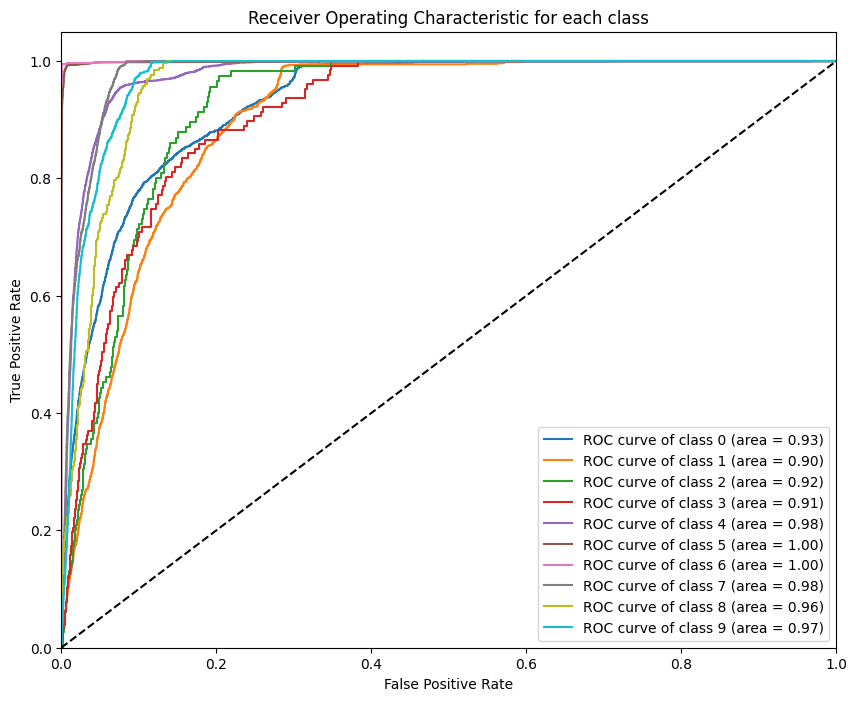

24420.85316967964


In [9]:
# 提取特征和标签
X = data_sample.drop(columns=['timestamp', 'label']).values
y = data_sample['label'].values

start= time.time()

# 定义模型参数
input_size = X.shape[1]
hidden_size = 32
output_size = len(np.unique(y))
num_layers = 1
dropout = 0.0
bidirectional = False
optimizer_params = {'lr': 0.01}

# 定义网格搜索的参数范围
param_grid = {
    'num_layers': [1,2],
    'dropout': [0.0,0.2],
    'bidirectional': [False],
    'optimizer_params': [{'lr': 0.01},{'lr': 0.001},{'lr': 0.1}]
}

# 初始化LSTMClassifierWrapper
lstm_classifier = LSTMClassifierWrapper(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_layers=num_layers,
    dropout=dropout,
    bidirectional=bidirectional,
    optimizer_params=optimizer_params
)

# 执行网格搜索
lstm_classifier.fit(
    X=X,
    y=y,
    sequence_length=10,  # 序列长度
    batch_size=10000,  # 批量大小
    num_epochs=5,  # 训练轮数
    test_size=0.2,  # 测试集的比例
    random_state=2024,  # 随机种子
    grid_search=True,  # 启用网格搜索
    param_grid=param_grid,  # 网格搜索的参数范围
    cv=3  # 交叉验证的折数
)

end= time.time()
print(end-start)

- 不使用网格搜索

Epoch [1/10], Loss: 2.1317, Validation Accuracy: 0.6198
Epoch [2/10], Loss: 1.5129, Validation Accuracy: 0.6198
Epoch [3/10], Loss: 1.3757, Validation Accuracy: 0.6198
Epoch [4/10], Loss: 1.2943, Validation Accuracy: 0.6198
Epoch [5/10], Loss: 1.2580, Validation Accuracy: 0.6198
Epoch [6/10], Loss: 1.2215, Validation Accuracy: 0.6198
Epoch [7/10], Loss: 1.1698, Validation Accuracy: 0.6198
Epoch [8/10], Loss: 1.1062, Validation Accuracy: 0.6198
Epoch [9/10], Loss: 1.0377, Validation Accuracy: 0.6198
Epoch [10/10], Loss: 0.9659, Validation Accuracy: 0.7396
Epoch [1/10], Loss: 0.8746, Validation Accuracy: 0.7671
Epoch [2/10], Loss: 0.7700, Validation Accuracy: 0.7658
Epoch [3/10], Loss: 0.6979, Validation Accuracy: 0.7651
Epoch [4/10], Loss: 0.6512, Validation Accuracy: 0.7849
Epoch [5/10], Loss: 0.6210, Validation Accuracy: 0.7953
Epoch [6/10], Loss: 0.6005, Validation Accuracy: 0.7979
Epoch [7/10], Loss: 0.5853, Validation Accuracy: 0.8023
Epoch [8/10], Loss: 0.5717, Validation Accuracy

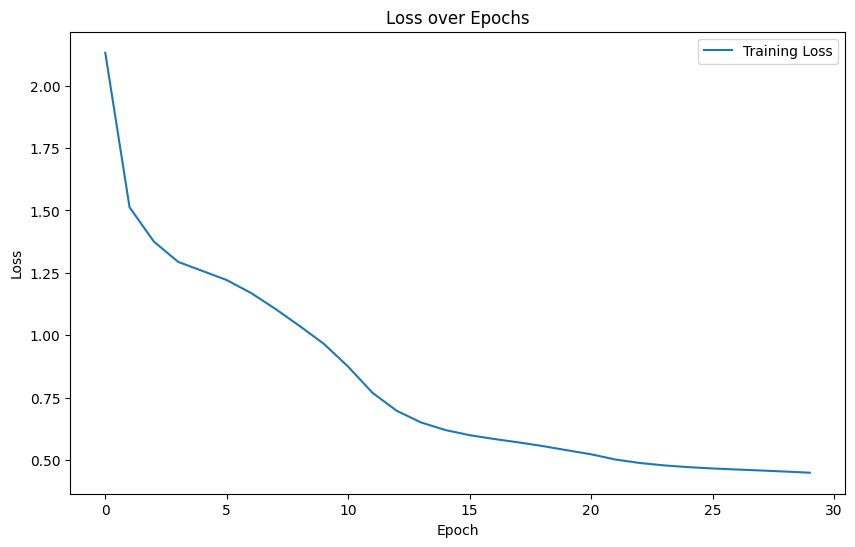

              precision    recall  f1-score   support

           0       0.51      0.06      0.10      2089
           1       0.00      0.00      0.00      1069
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00       127
           4       0.63      0.96      0.76      5233
           5       0.99      0.99      0.99     21068
           6       0.99      0.96      0.98      1065
           7       0.51      0.91      0.66      2069
           8       0.00      0.00      0.00       261
           9       0.55      0.03      0.05       953

    accuracy                           0.85     34049
   macro avg       0.42      0.39      0.35     34049
weighted avg       0.82      0.85      0.81     34049

Recall for class 0: 0.0565
Recall for class 1: 0.0000
Recall for class 2: 0.0000
Recall for class 3: 0.0000
Recall for class 4: 0.9591
Recall for class 5: 0.9931
Recall for class 6: 0.9634
Recall for class 7: 0.9082
Recall for class 8: 0.000

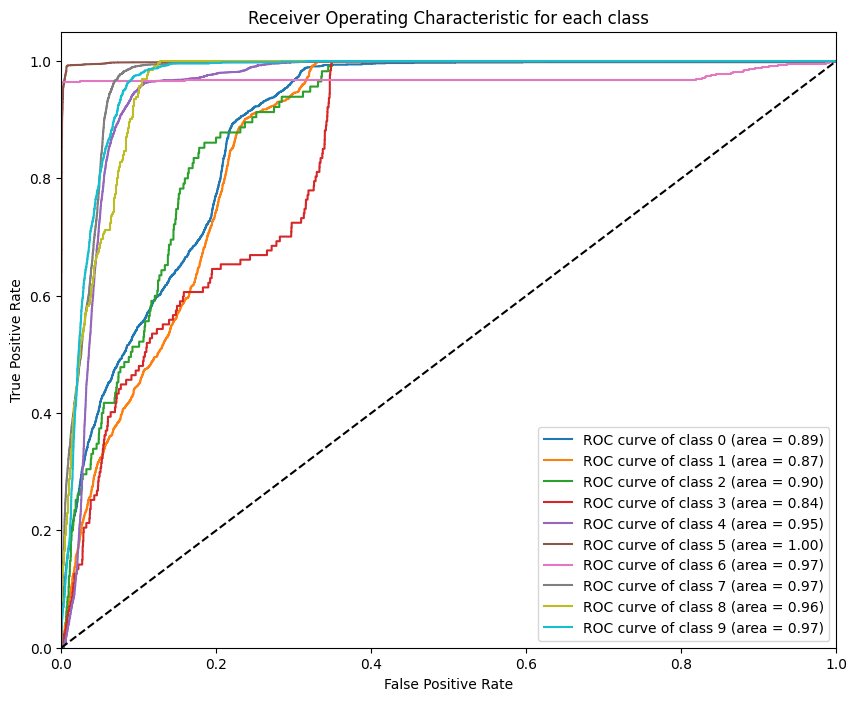

3869.0120985507965


In [19]:
# 提取特征和标签
X = data_sample.drop(columns=['timestamp', 'label']).values
y = data_sample['label'].values

start=time.time()

# 定义模型参数
input_size = X.shape[1]
hidden_size = 32
output_size = len(np.unique(y))
num_layers = 1
dropout = 0.0
bidirectional = False
optimizer_params = {'lr': 0.01}

# 创建LSTMClassifierWrapper实例
lstm_classifier = LSTMClassifierWrapper(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_layers=num_layers,
    dropout=dropout,
    bidirectional=bidirectional,
    optimizer_params=optimizer_params
)

# 训练模型
lstm_classifier.fit(
    X=X,
    y=y,
    sequence_length=10,  # 序列长度
    batch_size=10000,       # 批量大小
    num_epochs=10,       # 训练轮数
    test_size=0.2,       # 测试集的比例
    random_state=2024,   # 随机种子
    grid_search=False    # 不使用网格搜索
)
end=time.time()
print(end-start)

## XGBoost算法实验

1. 根据路径读取数据，做数据预处理并检查种类数

In [3]:
path_all = "../harth/*.csv"  # 更新为实际路径  
data = data_process(path_all)

文件: ../harth\S006.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth\S006.csv, 时间范围: ('2019-01-12 00:00:00', '2019-01-12 01:09:32')
原始数据标签: {1, 130, 3, 4, 5, 6, 7, 8, 13, 14}
新的数据标签: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
<bound method DataFrame.info of                      timestamp    back_x    back_y    back_z   thigh_x  \
0      2019-01-12 00:00:00.000 -0.760242  0.299570  0.468570 -5.092732   
1      2019-01-12 00:00:00.010 -0.530138  0.281880  0.319987  0.900547   
2      2019-01-12 00:00:00.020 -1.170922  0.186353 -0.167010 -0.035442   
3      2019-01-12 00:00:00.030 -0.648772  0.016579 -0.054284 -1.554248   
4      2019-01-12 00:00:00.040 -0.355071 -0.051831 -0.113419 -0.547471   
...                        ...       ...       ...       ...       ...   
408704 2019-01-12 01:09:32.880 -0.690417  0.035710 -0.697054  0.228261   
408705 2019-01-12 01:09:32.890 -0.745270  0.032438 -0.681320 -0.121986   
408706 2019-01-12 01:09:32.900 

In [4]:
# 随机抽取三分之一的样本  
n = len(data["back_x"])
sample_size = n // 3  
data_sample = data.sample(n=sample_size, random_state=2024)  
data_sample.info

<bound method DataFrame.info of                      timestamp    back_x    back_y    back_z   thigh_x  \
10490  2019-01-12 00:01:46.560 -0.984568  0.142520  0.052856 -0.973923   
256328 2019-01-12 00:43:44.640 -0.984992 -0.109124  0.050185 -0.982286   
340988 2019-01-12 00:58:06.000 -0.881127  0.264135  0.264181  0.205105   
160957 2019-01-12 00:27:46.000 -0.478163  0.000532 -0.873213  0.052054   
63678  2019-01-12 00:10:50.280 -0.952907  0.065564 -0.293759 -0.293596   
...                        ...       ...       ...       ...       ...   
253551 2019-01-12 00:43:12.980 -0.984512  0.129632 -0.007972  0.147391   
120302 2019-01-12 00:20:18.760 -0.982319  0.096712  0.020621 -0.973843   
139452 2019-01-12 00:23:43.430 -0.998903  0.097472  0.048370 -0.989865   
147228 2019-01-12 00:25:01.190 -0.967191 -0.097120  0.048772 -0.971921   
264216 2019-01-12 00:45:05.380 -0.257601 -0.849451 -0.443295  0.195124   

         thigh_y   thigh_z  label  
10490   0.046229 -0.226257      4  
256328 

In [10]:
set(data_sample['label'].values)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

2. 提取特征和标签，创建XGBClassifier模型实例并训练

In [24]:
print(y)

[4 4 7 ... 4 4 6]


- 采用网格搜索

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Starting Grid Search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}
Mean Test Score: 0.8880 for parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Mean Test Score: 0.8879 for parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean Test Score: 0.8898 for parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mean Test Score: 0.8897 for parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Mean Test Score: 0.8924 for parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Mean Test Score: 0.8923 for parameters

E:\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:14:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8243
           1       0.98      0.85      0.91      4190
           2       1.00      0.99      1.00       458
           3       1.00      1.00      1.00       504
           4       0.97      0.99      0.98     20884
           5       1.00      1.00      1.00     84320
           6       1.00      1.00      1.00      4362
           7       0.96      0.98      0.97      8358
           8       1.00      0.93      0.96      1069
           9       0.95      0.95      0.95      3848

    accuracy                           0.99    136236
   macro avg       0.98      0.97      0.97    136236
weighted avg       0.99      0.99      0.99    136236

Validation Accuracy: 0.9889
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8243
           1       0.98      0.85      0.91      4190
    

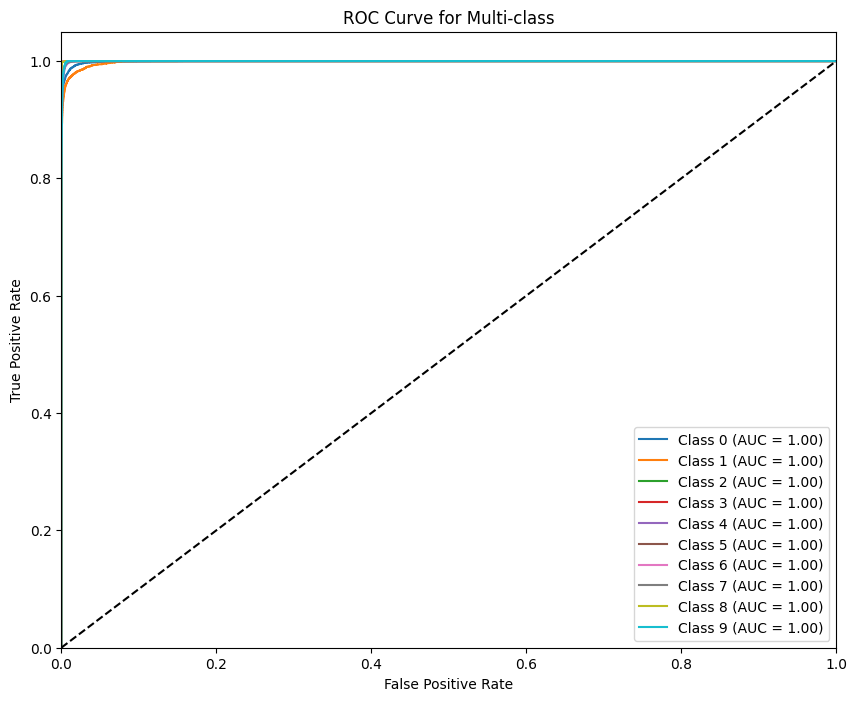

5992.286725521088


In [10]:
# 提取特征和标签
X = data_sample.drop(columns=['timestamp', 'label']).values
y = data_sample['label'].values

# 获取当前时间戳  
start = time.time()  

# 创建 XGBClassifier 实例  
model = XGBoostClassifier()  

# 定义参数网格
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}   

# 训练模型 
model.train(X, y, n_splits=5, grid_search=True, param_grid=param_grid)  

# 模型评估  
model.evaluate(X, y)  

# 获取当前时间戳  
end = time.time()  

# 转换为可读格式  
print(end - start) 

- 不采用网格搜索，直接定义超参数取值，观察损失函数值随树建立的变化图

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[0]	validation_0-mlogloss:1.91088
[1]	validation_0-mlogloss:1.65953
[2]	validation_0-mlogloss:1.47375
[3]	validation_0-mlogloss:1.32691
[4]	validation_0-mlogloss:1.20534
[5]	validation_0-mlogloss:1.10306
[6]	validation_0-mlogloss:1.01507
[7]	validation_0-mlogloss:0.93862
[8]	validation_0-mlogloss:0.87090
[9]	validation_0-mlogloss:0.81039
[10]	validation_0-mlogloss:0.75712
[11]	validation_0-mlogloss:0.71009
[12]	validation_0-mlogloss:0.66822
[13]	validation_0-mlogloss:0.63049
[14]	validation_0-mlogloss:0.59717
[15]	validation_0-mlogloss:0.56656
[16]	validation_0-mlogloss:0.53916
[17]	validation_0-mlogloss:0.51407
[18]	validation_0-mlogloss:0.49215
[19]	validation_0-mlogloss:0.47202
[20]	validation_0-mlogloss:0.45322
[21]	validation_0-mlogloss:0.43631
[22]	validation_0-mlogloss:0.42116
[23]	validation_0-mlogloss:0.40716
[24]	validation_0-mlogloss:0.39482
[25]	validation_0-mlogloss:0.38313
[26]	validation_0-mlogloss:0.37285
[27]	validation_0-mlogloss:0.36305

E:\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:1.65686
[2]	validation_0-mlogloss:1.46989
[3]	validation_0-mlogloss:1.32195
[4]	validation_0-mlogloss:1.19978
[5]	validation_0-mlogloss:1.09713
[6]	validation_0-mlogloss:1.00863
[7]	validation_0-mlogloss:0.93171
[8]	validation_0-mlogloss:0.86385
[9]	validation_0-mlogloss:0.80326
[10]	validation_0-mlogloss:0.74962
[11]	validation_0-mlogloss:0.70225
[12]	validation_0-mlogloss:0.66049
[13]	validation_0-mlogloss:0.62283
[14]	validation_0-mlogloss:0.58936
[15]	validation_0-mlogloss:0.55861
[16]	validation_0-mlogloss:0.53113
[17]	validation_0-mlogloss:0.50609
[18]	validation_0-mlogloss:0.48390
[19]	validation_0-mlogloss:0.46362
[20]	validation_0-mlogloss:0.44492
[21]	validation_0-mlogloss:0.42795
[22]	validation_0-mlogloss:0.41256
[23]	validation_0-mlogloss:0.39843
[24]	validation_0-mlogloss:0.38596
[25]	validation_0-mlogloss:0.37442
[26]	validation_0-mlogloss:0.36393
[27]	validation_0-mlogloss:0.35421
[28]	validation_0-mlogloss:0.34511
[29]	validation_0-mlogloss:0.

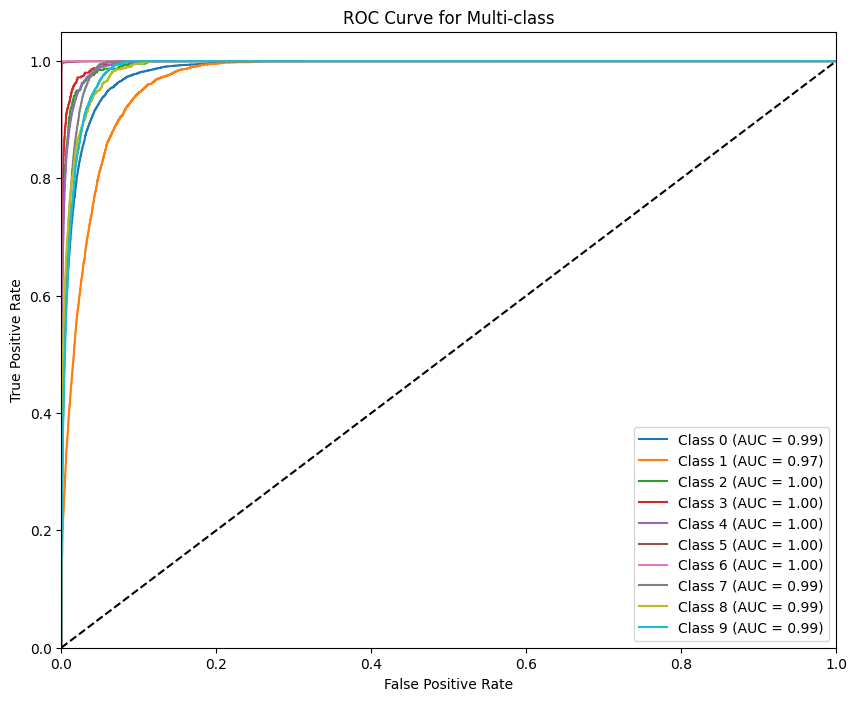

24.259629726409912


In [8]:
X = data_sample.drop(columns=['timestamp', 'label']).values
y = data_sample['label'].values

# 获取当前时间戳  
start = time.time()  

# 自定义超参数
custom_params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0
}

# 初始化 XGBClassifier 并传递自定义超参数
xgb_classifier = XGBoostClassifier(params=custom_params)

# 训练模型，不进行网格搜索
xgb_classifier.train(X, y, n_splits=5, grid_search=False)

# 评估模型
xgb_classifier.evaluate(X, y)

# 获取当前时间戳  
end = time.time()  

# 计算时间
print(end - start) 

## Random Forest算法实验

1. 根据路径读取数据，做数据预处理并检查种类数

In [40]:
path_all = "../harth/*.csv"  # 更新为实际路径  
data = data_process(path_all)

文件: ../harth\S006.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth\S006.csv, 时间范围: ('2019-01-12 00:00:00', '2019-01-12 01:09:32')
原始数据标签: {1, 130, 3, 4, 5, 6, 7, 8, 13, 14}
新的数据标签: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
<bound method DataFrame.info of                      timestamp    back_x    back_y    back_z   thigh_x  \
0      2019-01-12 00:00:00.000 -0.760242  0.299570  0.468570 -5.092732   
1      2019-01-12 00:00:00.010 -0.530138  0.281880  0.319987  0.900547   
2      2019-01-12 00:00:00.020 -1.170922  0.186353 -0.167010 -0.035442   
3      2019-01-12 00:00:00.030 -0.648772  0.016579 -0.054284 -1.554248   
4      2019-01-12 00:00:00.040 -0.355071 -0.051831 -0.113419 -0.547471   
...                        ...       ...       ...       ...       ...   
408704 2019-01-12 01:09:32.880 -0.690417  0.035710 -0.697054  0.228261   
408705 2019-01-12 01:09:32.890 -0.745270  0.032438 -0.681320 -0.121986   
408706 2019-01-12 01:09:32.900 

In [43]:
# 抽取三分之一的样本  
n = len(data["back_x"])
sample_size = n // 3  
data_sample = data.sample(n=sample_size, random_state=2024)
data_sample.info

<bound method DataFrame.info of                      timestamp    back_x    back_y    back_z   thigh_x  \
10490  2019-01-12 00:01:46.560 -0.984568  0.142520  0.052856 -0.973923   
256328 2019-01-12 00:43:44.640 -0.984992 -0.109124  0.050185 -0.982286   
340988 2019-01-12 00:58:06.000 -0.881127  0.264135  0.264181  0.205105   
160957 2019-01-12 00:27:46.000 -0.478163  0.000532 -0.873213  0.052054   
63678  2019-01-12 00:10:50.280 -0.952907  0.065564 -0.293759 -0.293596   
...                        ...       ...       ...       ...       ...   
253551 2019-01-12 00:43:12.980 -0.984512  0.129632 -0.007972  0.147391   
120302 2019-01-12 00:20:18.760 -0.982319  0.096712  0.020621 -0.973843   
139452 2019-01-12 00:23:43.430 -0.998903  0.097472  0.048370 -0.989865   
147228 2019-01-12 00:25:01.190 -0.967191 -0.097120  0.048772 -0.971921   
264216 2019-01-12 00:45:05.380 -0.257601 -0.849451 -0.443295  0.195124   

         thigh_y   thigh_z  label  
10490   0.046229 -0.226257      4  
256328 

2. 提取特征和标签，创建RFClassifier模型实例并训练

- 采用网格搜索

Fold 1 - Evaluating parameters: n_estimators
Fold 1 - Evaluating parameters: max_depth
Fold 1 - Evaluating parameters: min_samples_split
Fold 1 - Evaluating parameters: min_samples_leaf
Fold 1 - Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 40}
Fold 1 - Validation Accuracy: 0.5391
Fold 1 - Confusion Matrix:
 [[  935     2     0     1     0     0    38   204    92   137]
 [  473     2     2     0     2     0     3   107    45    47]
 [   46     0     0     0     0     0     0     5     6    18]
 [   53     0     0     1     0     0     0    10     2    13]
 [ 2981     0     0     0     0     2    45   174   121   136]
 [  582    37     1     2    23 10109  1152  1868    13   257]
 [    6     0     0     0     0     0   748     0     0     1]
 [  411     1     1     0     1     0    58   242   141   495]
 [   88     0     0     0     0     0    12    28    19    32]
 [  224     0     0     0     1     1    10   109   145   185]]
F

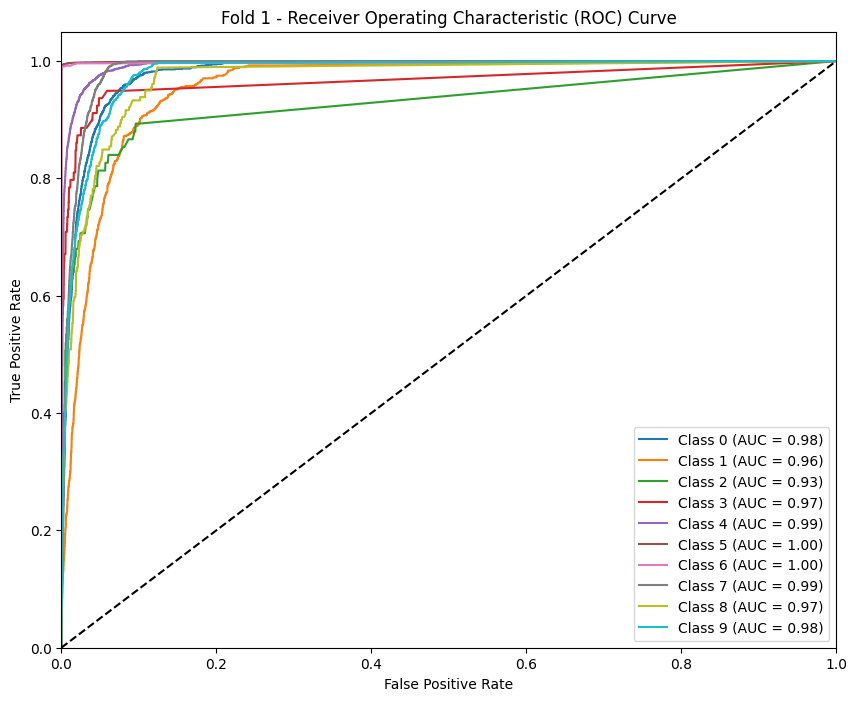

Fold 1 - Cohen's Kappa Score: 0.3381
Fold 1 - Macro F1 Score: 0.2010
Fold 1 - Micro F1 Score: 0.5391
Fold 2 - Evaluating parameters: n_estimators
Fold 2 - Evaluating parameters: max_depth
Fold 2 - Evaluating parameters: min_samples_split
Fold 2 - Evaluating parameters: min_samples_leaf
Fold 2 - Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
Fold 2 - Validation Accuracy: 0.5358
Fold 2 - Confusion Matrix:
 [[  781     7     0     1     0     0   146    99    40   248]
 [  391     8     1     0     0     0    75    68    22   138]
 [   37     0     0     0     0     0     6     6     0    21]
 [   52     1     0     0     0     0     2     4     5    18]
 [ 2842     1     0     0     0     5   120   175    39   295]
 [ 1317     5     1     8     3 10195  1231  1249    21    69]
 [    1     0     0     0     0     0   696     1     0     3]
 [  461     7     2     0     0     1    93   300   150   441]
 [   79     2     0     0  

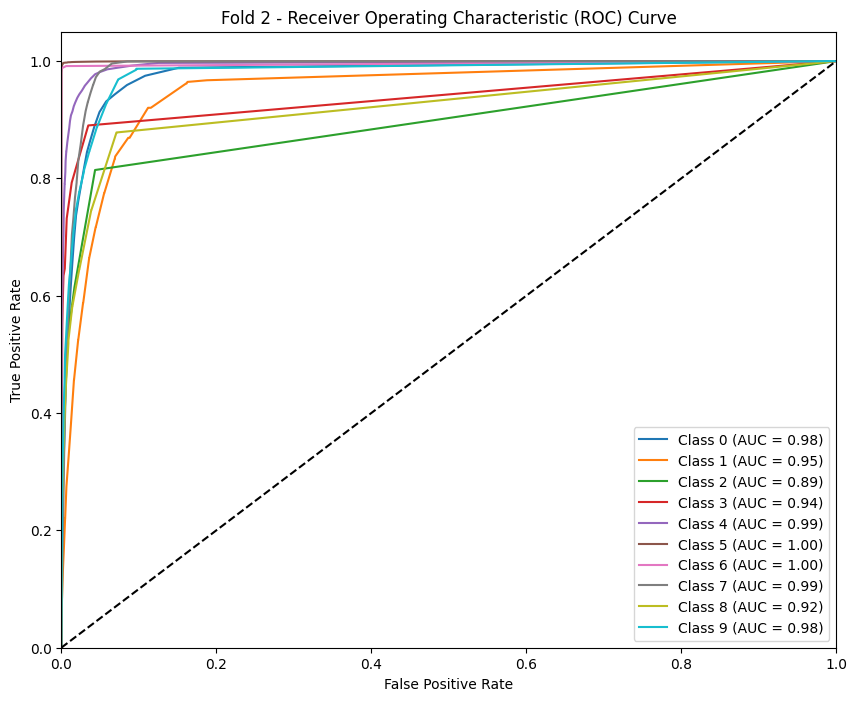

Fold 2 - Cohen's Kappa Score: 0.3313
Fold 2 - Macro F1 Score: 0.1911
Fold 2 - Micro F1 Score: 0.5358
Fold 3 - Evaluating parameters: n_estimators
Fold 3 - Evaluating parameters: max_depth
Fold 3 - Evaluating parameters: min_samples_split
Fold 3 - Evaluating parameters: min_samples_leaf
Fold 3 - Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}
Fold 3 - Validation Accuracy: 0.5547
Fold 3 - Confusion Matrix:
 [[  636     9     0     2     0     1    43   428    63   172]
 [  267     5     1     0     0     0     8   250    26   119]
 [   40     1     0     0     0     0     2    33     5     9]
 [   38     0     0     0     0     0     1    28    13    11]
 [ 2029     3     0     0     0     0    46   630    15   749]
 [ 1241     1     0     1     1 10512  1475   751    17    71]
 [    1     0     0     0     0    22   692     6     1     0]
 [  282     1     1     0     0     0    44   630   158   287]
 [   49     0     0     0  

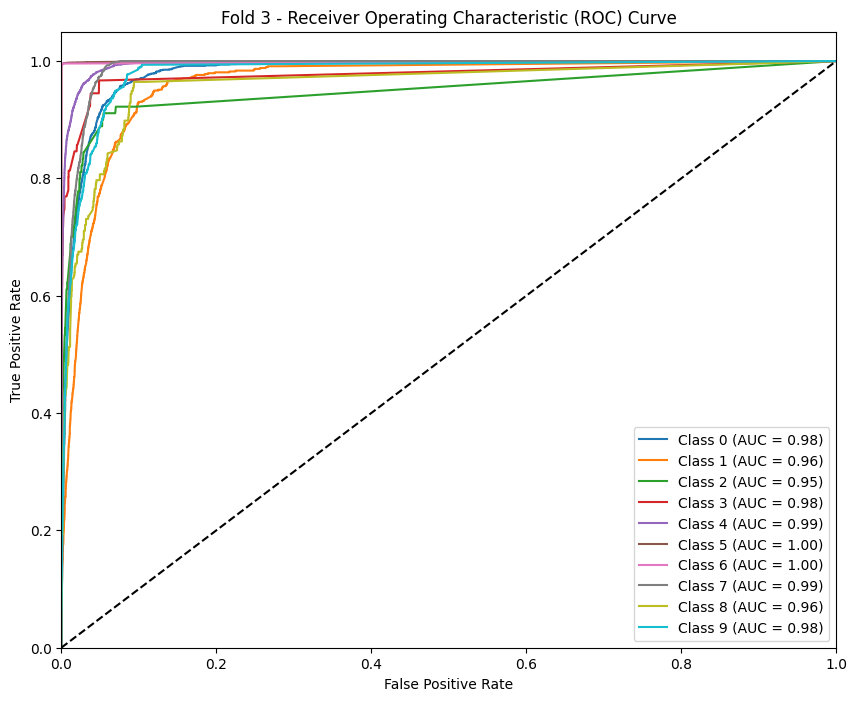

Fold 3 - Cohen's Kappa Score: 0.3511
Fold 3 - Macro F1 Score: 0.1973
Fold 3 - Micro F1 Score: 0.5547
Fold 4 - Evaluating parameters: n_estimators
Fold 4 - Evaluating parameters: max_depth
Fold 4 - Evaluating parameters: min_samples_split
Fold 4 - Evaluating parameters: min_samples_leaf
Fold 4 - Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}
Fold 4 - Validation Accuracy: 0.5900
Fold 4 - Confusion Matrix:
 [[  757     3     0     3     0     3    70   247    18   257]
 [  362     2     1     0     0     0    24   160     9   166]
 [   23     0     0     0     0     0     2    18     1    29]
 [   54     1     0     0     0     0     3    12     4    10]
 [ 1691     0     0     0     0    18    43  1375     0   362]
 [  960    64     1    17     0 11192   904   834     3    59]
 [    0     0     0     0     0     3   716     0     0     0]
 [  317     7     0     0     1     0    40   473    67   476]
 [   52     1     0     0  

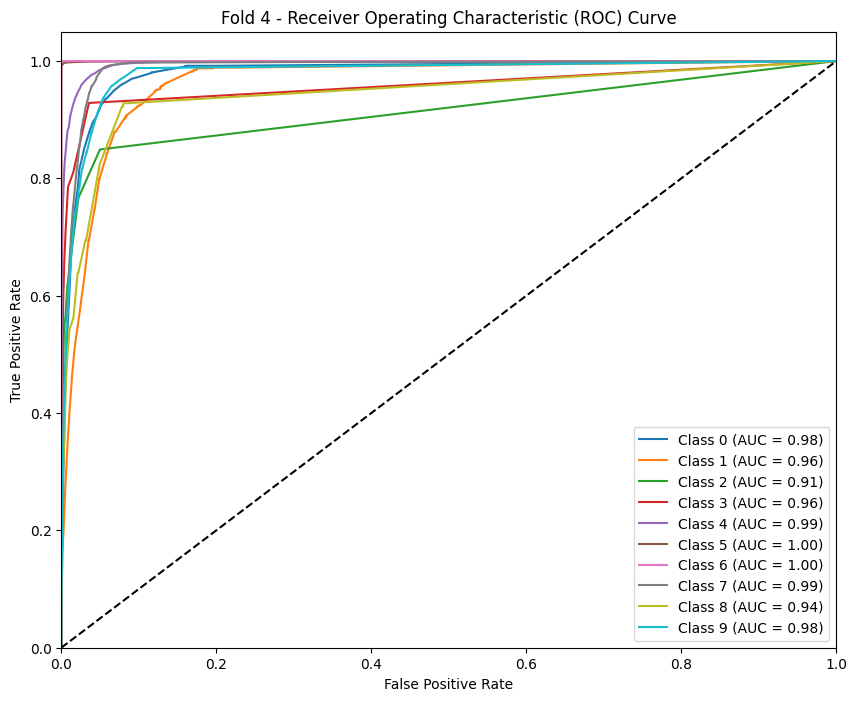

Fold 4 - Cohen's Kappa Score: 0.3874
Fold 4 - Macro F1 Score: 0.2173
Fold 4 - Micro F1 Score: 0.5900
Fold 5 - Evaluating parameters: n_estimators
Fold 5 - Evaluating parameters: max_depth
Fold 5 - Evaluating parameters: min_samples_split
Fold 5 - Evaluating parameters: min_samples_leaf
Fold 5 - Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
Fold 5 - Validation Accuracy: 0.4911
Fold 5 - Confusion Matrix:
 [[ 720    4    0    1    0    0  122  238   30  295]
 [ 253    3    0    0    2    0   38  213    8  182]
 [  37    0    0    0    0    0    3   15    6   20]
 [  55    0    0    0    0    0    2    7    3   15]
 [1167    4    2    0    0   52  123 1650    8  472]
 [1380   26    4    3 2049 9142  860  474    3   93]
 [   1    0    0    0    0  115  609    1    0    1]
 [ 312    6    3    0    0    1  113  387   85  489]
 [  57    0    0    0    0    0   34   20   12   56]
 [ 111    1    0    0    0    0   36  151   44  277]]


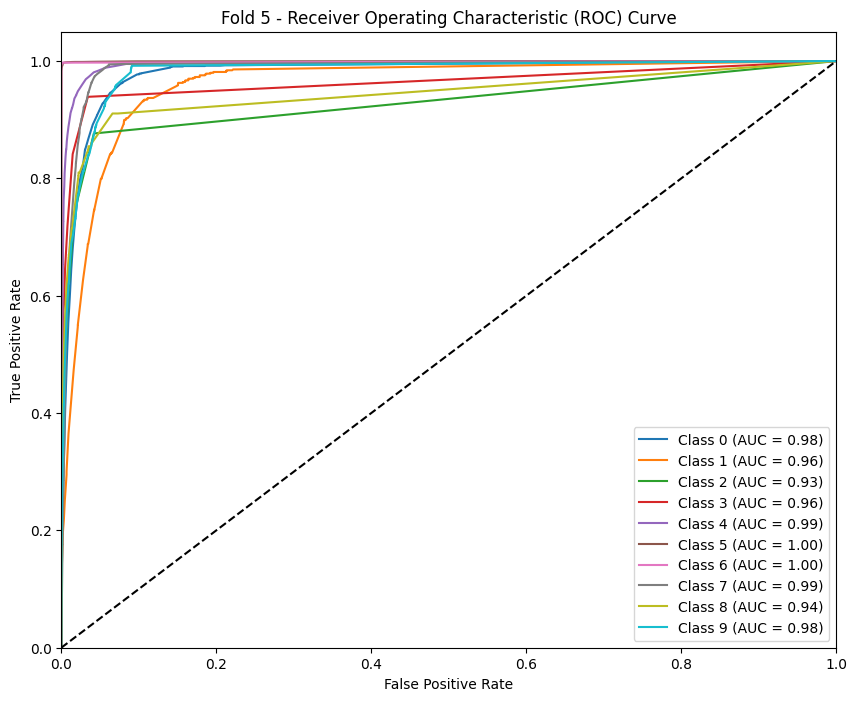

Fold 5 - Cohen's Kappa Score: 0.2810
Fold 5 - Macro F1 Score: 0.1963
Fold 5 - Micro F1 Score: 0.4911
526.1722090244293


In [51]:
X = data_sample.drop(columns=['timestamp', 'label']).values
y = data_sample['label'].values

# 获取当前时间戳  
start = time.time()  

# 定义参数网格
param_grid = {
    'n_estimators': [30,40],
    'max_depth': [5, 10, 20,30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 实例化 RFClassifier
rf_classifier = RFClassifier()

# 调用 fit 方法进行训练，并启用网格搜索
rf_classifier.fit(X, y, n_splits=5, grid_search=True, param_grid=param_grid, cv=3)

# 获取当前时间戳  
end = time.time()  

# 计算时间
print(end - start) 

E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 1: OOB Score = 0.3604
Fold 1 - Iteration 2: OOB Score = 0.5536


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 3: OOB Score = 0.6729


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 4: OOB Score = 0.7580


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 5: OOB Score = 0.8067


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 6: OOB Score = 0.8386


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 7: OOB Score = 0.8622


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 8: OOB Score = 0.8739


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 9: OOB Score = 0.8842


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 10: OOB Score = 0.8892


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 11: OOB Score = 0.8937


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 12: OOB Score = 0.8943


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 13: OOB Score = 0.8984


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 14: OOB Score = 0.8995


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 15: OOB Score = 0.9021


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 16: OOB Score = 0.8995


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 17: OOB Score = 0.9017


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 18: OOB Score = 0.9021


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 19: OOB Score = 0.9033


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 20: OOB Score = 0.9033


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 21: OOB Score = 0.9061
Fold 1 - Iteration 22: OOB Score = 0.9051


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 1 - Iteration 23: OOB Score = 0.9055
Fold 1 - Iteration 24: OOB Score = 0.9058
Fold 1 - Iteration 25: OOB Score = 0.9065
Fold 1 - Iteration 26: OOB Score = 0.9056
Fold 1 - Iteration 27: OOB Score = 0.9052
Fold 1 - Iteration 28: OOB Score = 0.9046
Fold 1 - Iteration 29: OOB Score = 0.9058
Fold 1 - Iteration 30: OOB Score = 0.9062
Fold 1 - Iteration 31: OOB Score = 0.9070
Fold 1 - Iteration 32: OOB Score = 0.9061
Fold 1 - Iteration 33: OOB Score = 0.9055
Fold 1 - Iteration 34: OOB Score = 0.9066
Fold 1 - Iteration 35: OOB Score = 0.9063
Fold 1 - Iteration 36: OOB Score = 0.9069
Fold 1 - Iteration 37: OOB Score = 0.9065
Fold 1 - Iteration 38: OOB Score = 0.9076
Fold 1 - Iteration 39: OOB Score = 0.9069
Fold 1 - Iteration 40: OOB Score = 0.9071
Fold 1 - Iteration 41: OOB Score = 0.9078
Fold 1 - Iteration 42: OOB Score = 0.9076
Fold 1 - Iteration 43: OOB Score = 0.9085
Fold 1 - Iteration 44: OOB Score = 0.9083
Fold 1 - Iteration 45: OOB Score = 0.9084
Fold 1 - Iteration 46: OOB Score =

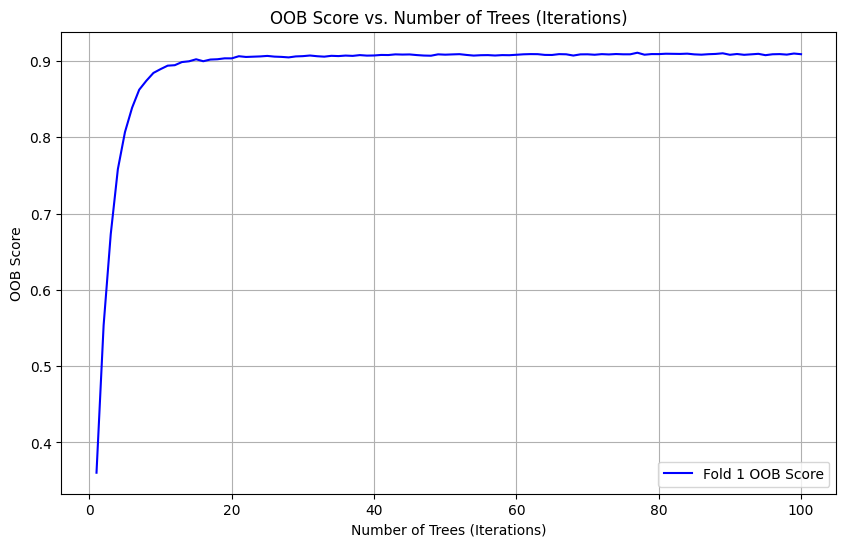

Fold 1 - Validation Accuracy: 0.5155
Fold 1 - Confusion Matrix:
 [[1004    2    0    1    0    0   30  303   18   51]
 [ 479    0    0    0    2    0    3  179    4   14]
 [  47    0    0    0    0    0    0   21    4    3]
 [  55    0    0    1    0    0    0   17    1    5]
 [2999    0    0    0    0   15   31  398    0   16]
 [1266    0    0    0    1 9414 1028 2331    1    3]
 [   7    0    0    0    0    1  747    0    0    0]
 [ 501    1    0    0    4    0   26  424  129  265]
 [ 100    0    0    0    0    0    9   40   19   11]
 [ 317    0    0    0    5    1    5  208   44   95]]
Fold 1 - Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.71      0.25      1409
           1       0.00      0.00      0.00       681
           2       0.00      0.00      0.00        75
           3       0.50      0.01      0.02        79
           4       0.00      0.00      0.00      3459
           5       1.00      0.67      0.80   

E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


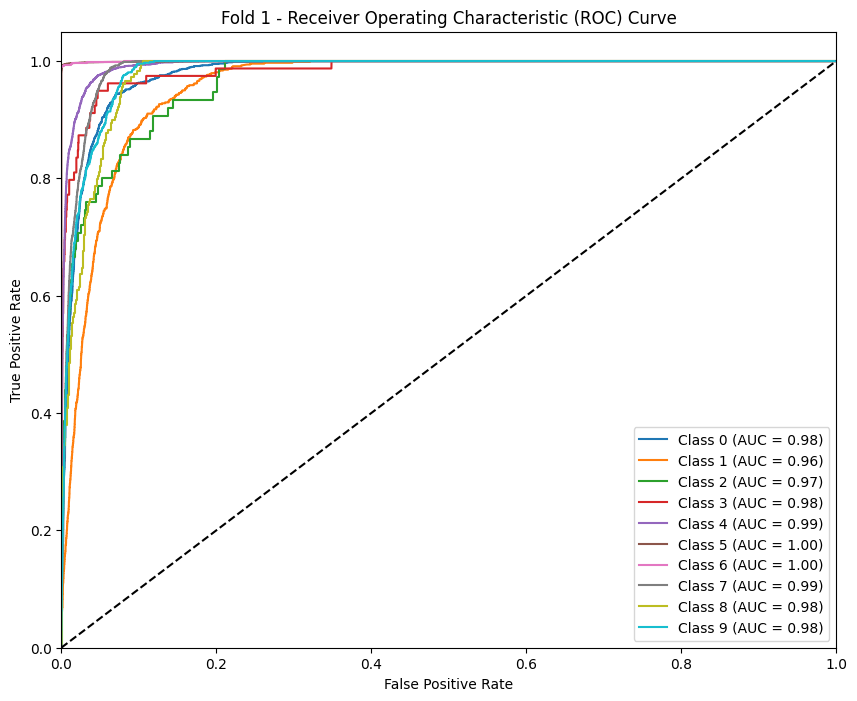

Fold 1 - Cohen's Kappa Score: 0.3183
Fold 1 - Macro F1 Score: 0.2062
Fold 1 - Micro F1 Score: 0.5155
Fold 2 - Iteration 1: OOB Score = 0.3695


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 2: OOB Score = 0.5591


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 3: OOB Score = 0.6828


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 4: OOB Score = 0.7634


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 5: OOB Score = 0.8113


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 6: OOB Score = 0.8457


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 7: OOB Score = 0.8670


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 8: OOB Score = 0.8780


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 9: OOB Score = 0.8868


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 10: OOB Score = 0.8935


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 11: OOB Score = 0.8993


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 12: OOB Score = 0.9015


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 13: OOB Score = 0.9023


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 14: OOB Score = 0.9036


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 15: OOB Score = 0.9032


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 16: OOB Score = 0.9055


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 17: OOB Score = 0.9055


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 18: OOB Score = 0.9064


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 19: OOB Score = 0.9066


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 20: OOB Score = 0.9075


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 21: OOB Score = 0.9067


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 22: OOB Score = 0.9086


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 23: OOB Score = 0.9078


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 2 - Iteration 24: OOB Score = 0.9077
Fold 2 - Iteration 25: OOB Score = 0.9073
Fold 2 - Iteration 26: OOB Score = 0.9091
Fold 2 - Iteration 27: OOB Score = 0.9088
Fold 2 - Iteration 28: OOB Score = 0.9104
Fold 2 - Iteration 29: OOB Score = 0.9083
Fold 2 - Iteration 30: OOB Score = 0.9090
Fold 2 - Iteration 31: OOB Score = 0.9099
Fold 2 - Iteration 32: OOB Score = 0.9089
Fold 2 - Iteration 33: OOB Score = 0.9089
Fold 2 - Iteration 34: OOB Score = 0.9095
Fold 2 - Iteration 35: OOB Score = 0.9091
Fold 2 - Iteration 36: OOB Score = 0.9095
Fold 2 - Iteration 37: OOB Score = 0.9102
Fold 2 - Iteration 38: OOB Score = 0.9103
Fold 2 - Iteration 39: OOB Score = 0.9090
Fold 2 - Iteration 40: OOB Score = 0.9095
Fold 2 - Iteration 41: OOB Score = 0.9098
Fold 2 - Iteration 42: OOB Score = 0.9102
Fold 2 - Iteration 43: OOB Score = 0.9094
Fold 2 - Iteration 44: OOB Score = 0.9084
Fold 2 - Iteration 45: OOB Score = 0.9098
Fold 2 - Iteration 46: OOB Score = 0.9095
Fold 2 - Iteration 47: OOB Score =

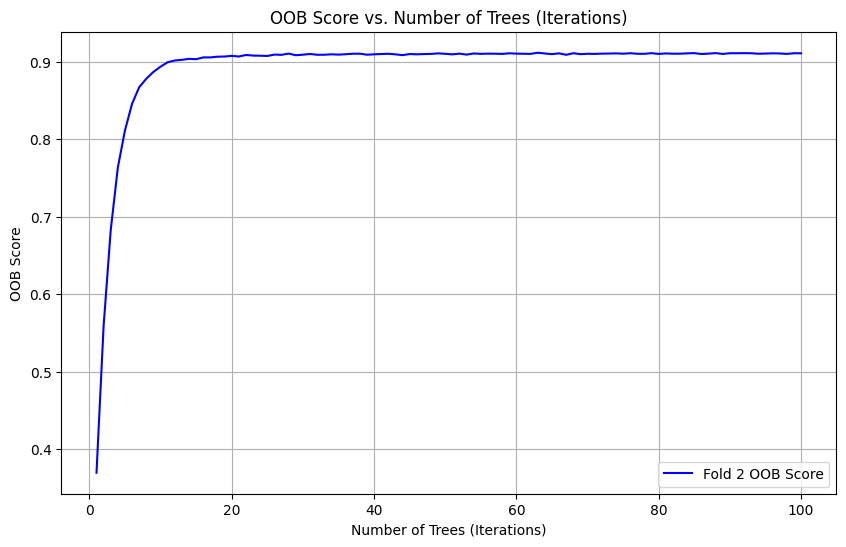

Fold 2 - Validation Accuracy: 0.6050
Fold 2 - Confusion Matrix:
 [[  933     1     1     0     0     0    39   268    12    68]
 [  480     0     1     0     0     0     3   208     4     7]
 [   50     0     0     0     0     0     0    12     0     8]
 [   63     0     0     0     0     0     1    11     3     4]
 [ 2953     0     0     0     0    27    15   462     1    19]
 [  577     2     0     0     1 11454   860  1202     1     2]
 [    3     0     0     0     0     1   694     2     0     1]
 [  468     2     0     0     2     0    43   546    60   334]
 [   93     0     0     0     0     0    12    52     8    24]
 [  269     1     0     0     0     0     7   189    40   102]]
Fold 2 - Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.71      0.26      1322
           1       0.00      0.00      0.00       703
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00        82


E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


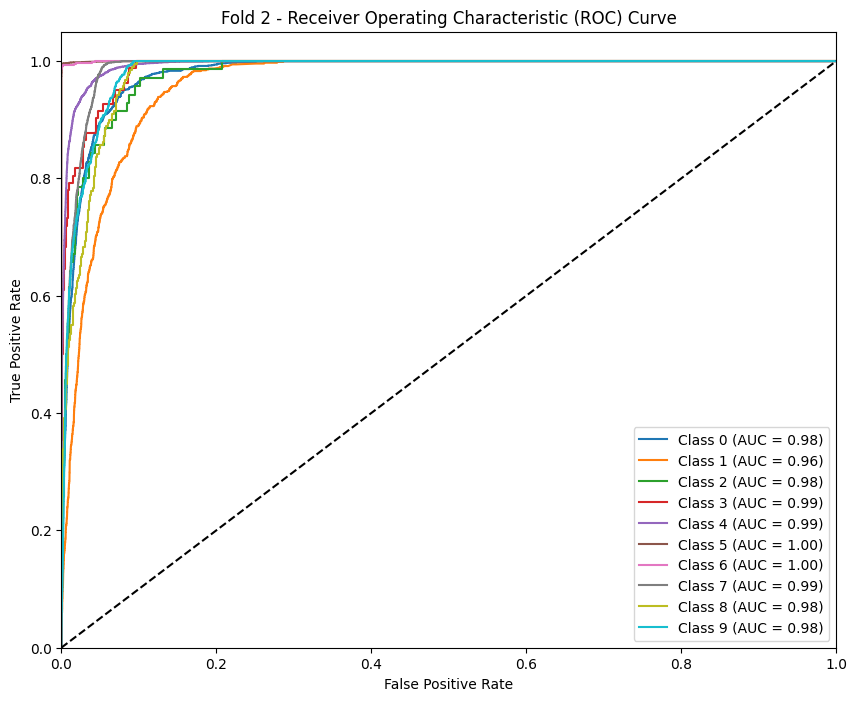

Fold 2 - Cohen's Kappa Score: 0.4011
Fold 2 - Macro F1 Score: 0.2210
Fold 2 - Micro F1 Score: 0.6050


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 1: OOB Score = 0.3683


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 2: OOB Score = 0.5619


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 3: OOB Score = 0.6824


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 4: OOB Score = 0.7624


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 5: OOB Score = 0.8131


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 6: OOB Score = 0.8491


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 7: OOB Score = 0.8689


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 8: OOB Score = 0.8796


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 9: OOB Score = 0.8897


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 10: OOB Score = 0.8950


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 11: OOB Score = 0.8999


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 12: OOB Score = 0.9021


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 13: OOB Score = 0.9042


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 14: OOB Score = 0.9069


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 15: OOB Score = 0.9065


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 16: OOB Score = 0.9072


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 17: OOB Score = 0.9081


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 18: OOB Score = 0.9085


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 19: OOB Score = 0.9082


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 20: OOB Score = 0.9090


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 21: OOB Score = 0.9087
Fold 3 - Iteration 22: OOB Score = 0.9091


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 23: OOB Score = 0.9098


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 3 - Iteration 24: OOB Score = 0.9088
Fold 3 - Iteration 25: OOB Score = 0.9105
Fold 3 - Iteration 26: OOB Score = 0.9094
Fold 3 - Iteration 27: OOB Score = 0.9100
Fold 3 - Iteration 28: OOB Score = 0.9111
Fold 3 - Iteration 29: OOB Score = 0.9109
Fold 3 - Iteration 30: OOB Score = 0.9099
Fold 3 - Iteration 31: OOB Score = 0.9105
Fold 3 - Iteration 32: OOB Score = 0.9104
Fold 3 - Iteration 33: OOB Score = 0.9106
Fold 3 - Iteration 34: OOB Score = 0.9113
Fold 3 - Iteration 35: OOB Score = 0.9106
Fold 3 - Iteration 36: OOB Score = 0.9106
Fold 3 - Iteration 37: OOB Score = 0.9106
Fold 3 - Iteration 38: OOB Score = 0.9106
Fold 3 - Iteration 39: OOB Score = 0.9108
Fold 3 - Iteration 40: OOB Score = 0.9106
Fold 3 - Iteration 41: OOB Score = 0.9108
Fold 3 - Iteration 42: OOB Score = 0.9109
Fold 3 - Iteration 43: OOB Score = 0.9110
Fold 3 - Iteration 44: OOB Score = 0.9117
Fold 3 - Iteration 45: OOB Score = 0.9116
Fold 3 - Iteration 46: OOB Score = 0.9112
Fold 3 - Iteration 47: OOB Score =

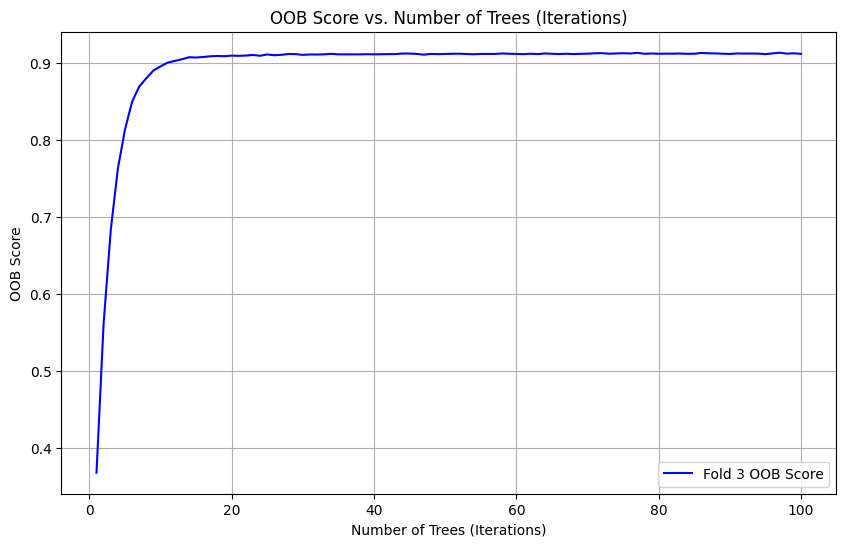

Fold 3 - Validation Accuracy: 0.5883
Fold 3 - Confusion Matrix:
 [[  962     3     0     0     1     1    36   297    27    27]
 [  433     2     1     0     0     0     6   203    27     4]
 [   59     0     0     0     0     0     2    20     5     4]
 [   60     0     0     0     0     0     0    27     2     2]
 [ 2948     0     0     0     0     7    37   458    20     2]
 [  617     1     1     0     0 11101   960  1379     7     4]
 [    7     0     0     0     0     5   710     0     0     0]
 [  450     1     1     0     1     0    76   489   145   240]
 [  100     0     0     0     0     0     8    44    26    19]
 [  253     1     0     0     0     0    20   219    69    69]]
Fold 3 - Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.71      0.27      1354
           1       0.25      0.00      0.01       676
           2       0.00      0.00      0.00        90
           3       0.00      0.00      0.00        91


E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


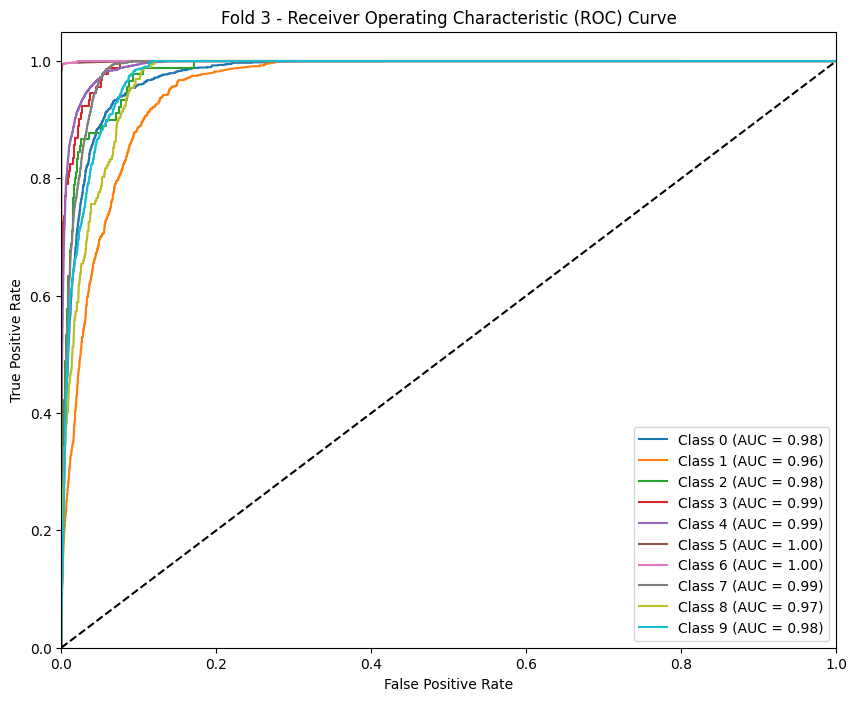

Fold 3 - Cohen's Kappa Score: 0.3851
Fold 3 - Macro F1 Score: 0.2156
Fold 3 - Micro F1 Score: 0.5883


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 1: OOB Score = 0.3640


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 2: OOB Score = 0.5596


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 3: OOB Score = 0.6847


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 4: OOB Score = 0.7628


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 5: OOB Score = 0.8160


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 6: OOB Score = 0.8483


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 7: OOB Score = 0.8693


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 8: OOB Score = 0.8835


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 9: OOB Score = 0.8908


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 10: OOB Score = 0.8964


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 11: OOB Score = 0.8996


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 12: OOB Score = 0.9023


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 13: OOB Score = 0.9048


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 14: OOB Score = 0.9066


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 15: OOB Score = 0.9064


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 16: OOB Score = 0.9069


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 17: OOB Score = 0.9089


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 18: OOB Score = 0.9082


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 19: OOB Score = 0.9089


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 20: OOB Score = 0.9078


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 21: OOB Score = 0.9084


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 22: OOB Score = 0.9097


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 23: OOB Score = 0.9086
Fold 4 - Iteration 24: OOB Score = 0.9086
Fold 4 - Iteration 25: OOB Score = 0.9100


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 4 - Iteration 26: OOB Score = 0.9106
Fold 4 - Iteration 27: OOB Score = 0.9099
Fold 4 - Iteration 28: OOB Score = 0.9099
Fold 4 - Iteration 29: OOB Score = 0.9098
Fold 4 - Iteration 30: OOB Score = 0.9097
Fold 4 - Iteration 31: OOB Score = 0.9096
Fold 4 - Iteration 32: OOB Score = 0.9108
Fold 4 - Iteration 33: OOB Score = 0.9104
Fold 4 - Iteration 34: OOB Score = 0.9105
Fold 4 - Iteration 35: OOB Score = 0.9107
Fold 4 - Iteration 36: OOB Score = 0.9097
Fold 4 - Iteration 37: OOB Score = 0.9102
Fold 4 - Iteration 38: OOB Score = 0.9114
Fold 4 - Iteration 39: OOB Score = 0.9105
Fold 4 - Iteration 40: OOB Score = 0.9103
Fold 4 - Iteration 41: OOB Score = 0.9112
Fold 4 - Iteration 42: OOB Score = 0.9110
Fold 4 - Iteration 43: OOB Score = 0.9116
Fold 4 - Iteration 44: OOB Score = 0.9105
Fold 4 - Iteration 45: OOB Score = 0.9106
Fold 4 - Iteration 46: OOB Score = 0.9110
Fold 4 - Iteration 47: OOB Score = 0.9113
Fold 4 - Iteration 48: OOB Score = 0.9109
Fold 4 - Iteration 49: OOB Score =

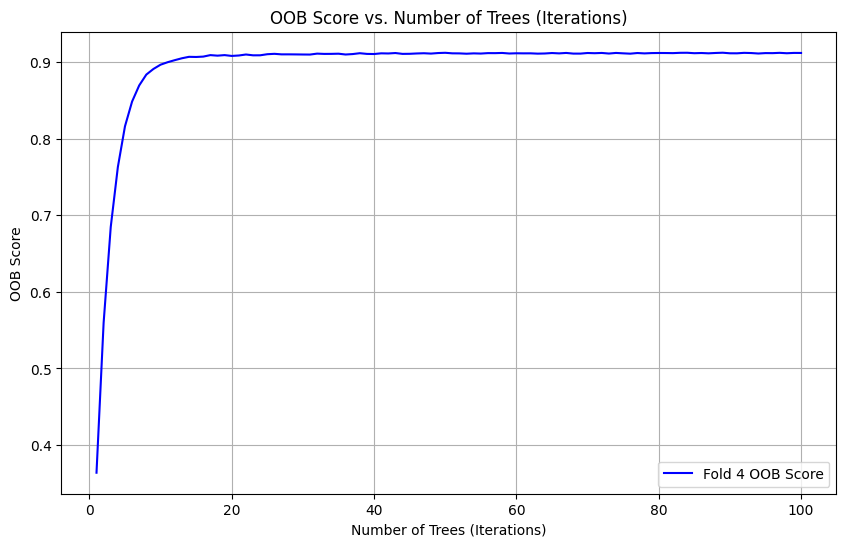

Fold 4 - Validation Accuracy: 0.6138
Fold 4 - Confusion Matrix:
 [[ 1007     0     0     0     0     2    39   200     9   101]
 [  525     0     0     0     0     0     4   150     7    38]
 [   46     0     0     0     0     0     0    10     0    17]
 [   68     1     0     0     0     0     0     6     1     8]
 [ 3003     0     0     0     0    37     8   386     0    55]
 [  533     2     0     0     0 11617   704  1163     3    12]
 [    1     0     0     0     0     3   715     0     0     0]
 [  495     3     0     0     0     1    61   412    85   324]
 [   91     0     0     0     1     0     5    34     9    40]
 [  275     1     0     0     0     1    16   149    46   176]]
Fold 4 - Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.74      0.27      1358
           1       0.00      0.00      0.00       724
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        84


E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


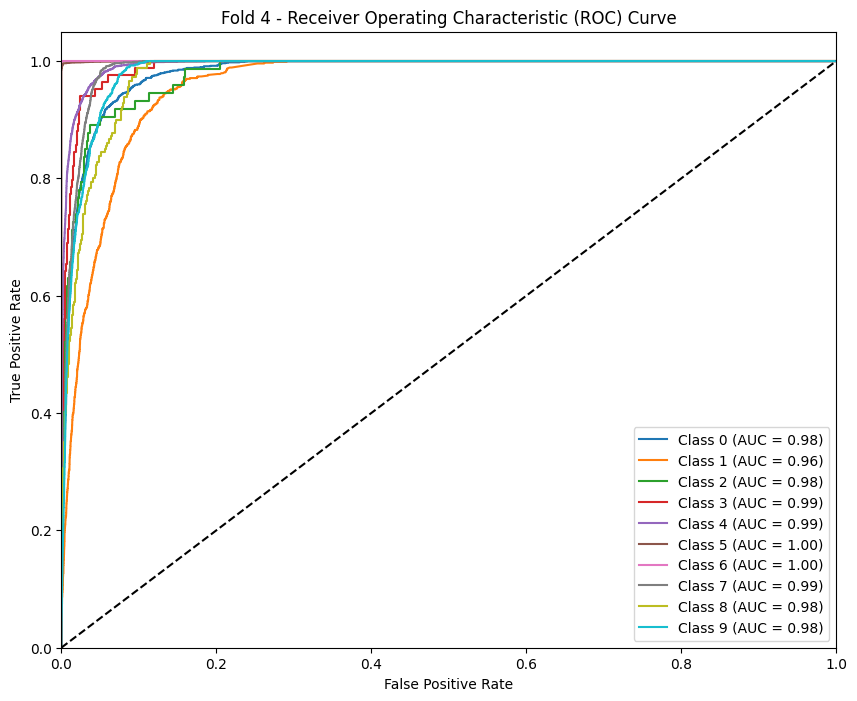

Fold 4 - Cohen's Kappa Score: 0.4118
Fold 4 - Macro F1 Score: 0.2316
Fold 4 - Micro F1 Score: 0.6138


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 1: OOB Score = 0.3660


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 2: OOB Score = 0.5634


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 3: OOB Score = 0.6872


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 4: OOB Score = 0.7668


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 5: OOB Score = 0.8143


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 6: OOB Score = 0.8483


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 7: OOB Score = 0.8690


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 8: OOB Score = 0.8823


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 9: OOB Score = 0.8913


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 10: OOB Score = 0.8964


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 11: OOB Score = 0.9011


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 12: OOB Score = 0.9043


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 13: OOB Score = 0.9054


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 14: OOB Score = 0.9052


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 15: OOB Score = 0.9083


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 16: OOB Score = 0.9072


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 17: OOB Score = 0.9088


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 18: OOB Score = 0.9090


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 19: OOB Score = 0.9097


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 20: OOB Score = 0.9090


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 21: OOB Score = 0.9089


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 22: OOB Score = 0.9108


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 23: OOB Score = 0.9097


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 24: OOB Score = 0.9097


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 25: OOB Score = 0.9102
Fold 5 - Iteration 26: OOB Score = 0.9101
Fold 5 - Iteration 27: OOB Score = 0.9109
Fold 5 - Iteration 28: OOB Score = 0.9108


E:\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Fold 5 - Iteration 29: OOB Score = 0.9111
Fold 5 - Iteration 30: OOB Score = 0.9104
Fold 5 - Iteration 31: OOB Score = 0.9100
Fold 5 - Iteration 32: OOB Score = 0.9099
Fold 5 - Iteration 33: OOB Score = 0.9106
Fold 5 - Iteration 34: OOB Score = 0.9111
Fold 5 - Iteration 35: OOB Score = 0.9108
Fold 5 - Iteration 36: OOB Score = 0.9104
Fold 5 - Iteration 37: OOB Score = 0.9102
Fold 5 - Iteration 38: OOB Score = 0.9116
Fold 5 - Iteration 39: OOB Score = 0.9118
Fold 5 - Iteration 40: OOB Score = 0.9112
Fold 5 - Iteration 41: OOB Score = 0.9110
Fold 5 - Iteration 42: OOB Score = 0.9111
Fold 5 - Iteration 43: OOB Score = 0.9103
Fold 5 - Iteration 44: OOB Score = 0.9106
Fold 5 - Iteration 45: OOB Score = 0.9111
Fold 5 - Iteration 46: OOB Score = 0.9115
Fold 5 - Iteration 47: OOB Score = 0.9111
Fold 5 - Iteration 48: OOB Score = 0.9114
Fold 5 - Iteration 49: OOB Score = 0.9104
Fold 5 - Iteration 50: OOB Score = 0.9117
Fold 5 - Iteration 51: OOB Score = 0.9113
Fold 5 - Iteration 52: OOB Score =

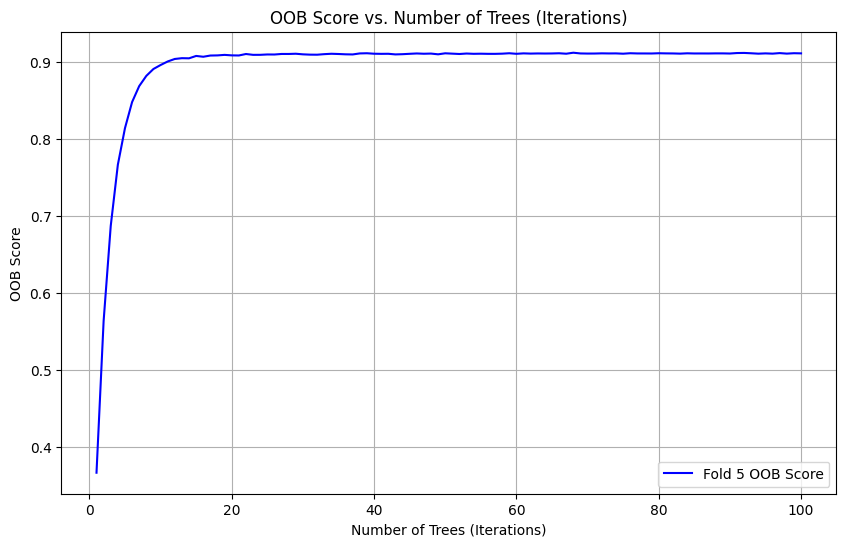

Fold 5 - Validation Accuracy: 0.5804
Fold 5 - Confusion Matrix:
 [[  995     1     0     0     0     0    38   213    15   148]
 [  500     1     0     0     0     0     5   149     5    39]
 [   44     0     0     0     0     0     1    13     5    18]
 [   59     0     0     0     0     0     0     9     2    12]
 [ 2985     0     1     0     0    53     7   361     1    70]
 [  522     2     0     0   695 10722   755  1326     1    11]
 [    1     0     0     0     0     8   716     1     0     1]
 [  352     1     1     0     0     1    71   443    63   464]
 [   72     0     0     0     0     0    11    23     6    67]
 [  145     0     0     0     0     0    13   122    44   296]]
Fold 5 - Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.71      0.28      1410
           1       0.20      0.00      0.00       699
           2       0.00      0.00      0.00        81
           3       0.00      0.00      0.00        82


E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


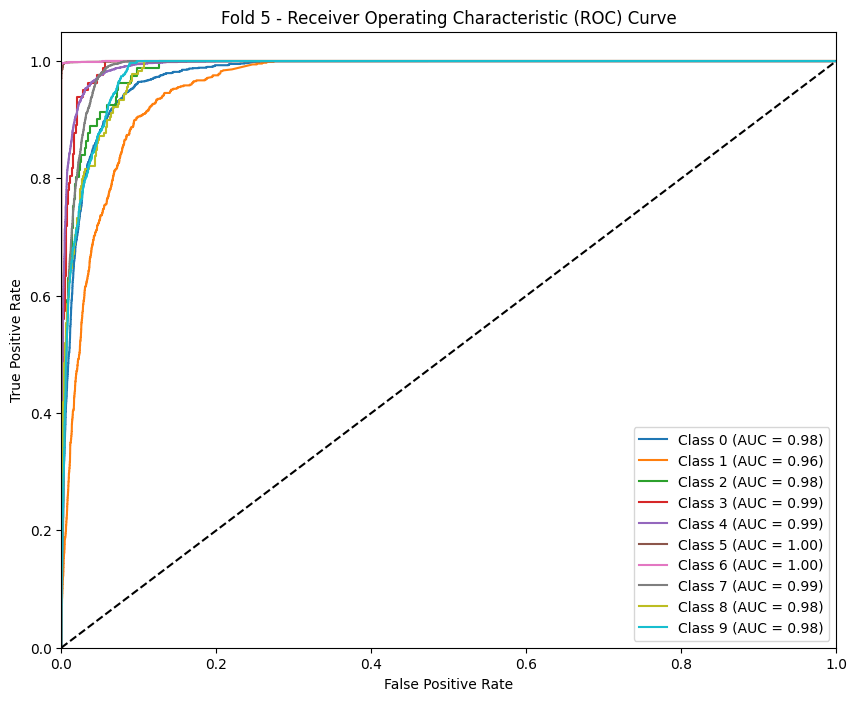

Fold 5 - Cohen's Kappa Score: 0.3787
Fold 5 - Macro F1 Score: 0.2354
Fold 5 - Micro F1 Score: 0.5804
4798.223363399506


In [45]:
X = data_sample.drop(columns=['timestamp', 'label']).values
y = data_sample['label'].values

start=time.time()

# 自定义参数
params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2
}

# 实例化 RFClassifier 并传递自定义参数
rf_classifier = RFClassifier(params=params)

# 调用 fit 方法进行训练，不启用网格搜索
rf_classifier.fit(X, y, n_splits=5, grid_search=False)

end = time.time()
print(end-start)

## EDA部分

1. 绘制空间轨迹图，读取S006.csv的全部数据

In [12]:
path = "../harth/*.csv"
df = data_process(path)

文件: ../harth\S006.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth\S006.csv, 时间范围: ('2019-01-12 00:00:00', '2019-01-12 01:09:32')
原始数据标签: {1, 130, 3, 4, 5, 6, 7, 8, 13, 14}
新的数据标签: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
<bound method DataFrame.info of                      timestamp    back_x    back_y    back_z   thigh_x  \
0      2019-01-12 00:00:00.000 -0.760242  0.299570  0.468570 -5.092732   
1      2019-01-12 00:00:00.010 -0.530138  0.281880  0.319987  0.900547   
2      2019-01-12 00:00:00.020 -1.170922  0.186353 -0.167010 -0.035442   
3      2019-01-12 00:00:00.030 -0.648772  0.016579 -0.054284 -1.554248   
4      2019-01-12 00:00:00.040 -0.355071 -0.051831 -0.113419 -0.547471   
...                        ...       ...       ...       ...       ...   
408704 2019-01-12 01:09:32.880 -0.690417  0.035710 -0.697054  0.228261   
408705 2019-01-12 01:09:32.890 -0.745270  0.032438 -0.681320 -0.121986   
408706 2019-01-12 01:09:32.900 

In [18]:
df.groupby('label').count()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z
label,,,,,,,
0,24889,24889,24889,24889,24889,24889,24889
1,12693,12693,12693,12693,12693,12693,12693
2,1370,1370,1370,1370,1370,1370,1370
3,1550,1550,1550,1550,1550,1550,1550
4,62682,62682,62682,62682,62682,62682,62682
5,253029,253029,253029,253029,253029,253029,253029
6,13036,13036,13036,13036,13036,13036,13036
7,25040,25040,25040,25040,25040,25040,25040
8,3130,3130,3130,3130,3130,3130,3130


- 走路状态空间轨迹图

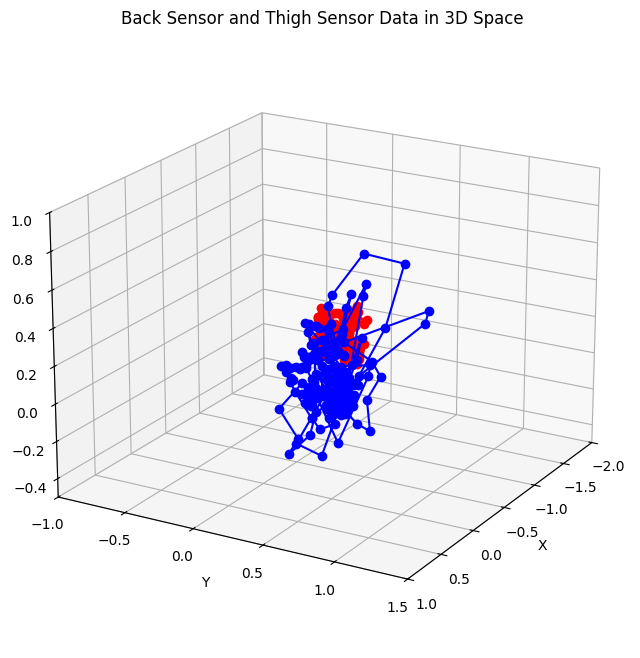

In [33]:
# 创建三维图  
fig = plt.figure(figsize=(10, 8))  
ax = fig.add_subplot(111, projection='3d')  

# 绘制 back_x, back_y, back_z 的三维散点图  
ax.plot(df.loc[17430:17654,'back_x'], df.loc[17430:17654,'back_y'], df.loc[17430:17654,'back_z'], c='r', marker='o')  
ax.plot(df.loc[17430:17654,'thigh_x'], df.loc[17430:17654,'thigh_y'], df.loc[17430:17654,'thigh_z'], c='b', marker='o')
# 添加标签和标题  
ax.set_title('Back Sensor and Thigh Sensor Data in 3D Space')  
ax.set_xlabel('X')  
ax.set_ylabel('Y')  
ax.set_zlabel('Z')  
# 设置坐标轴范围为正方向  
ax.set_xlim(-2, 1)  # 调整到最大值 (替换为你想要的范围)  
ax.set_ylim(-1, 1.5)  # 调整到最大值   
ax.set_zlim(-0.5, 1)  # 调整到最大值


# Optional: 设置视角  
ax.view_init(elev=20., azim=30)  # 设定合适的视点，可以根据需要调整  
plt.savefig("../figures/walk.jpg")

- 站立状态空间轨迹图

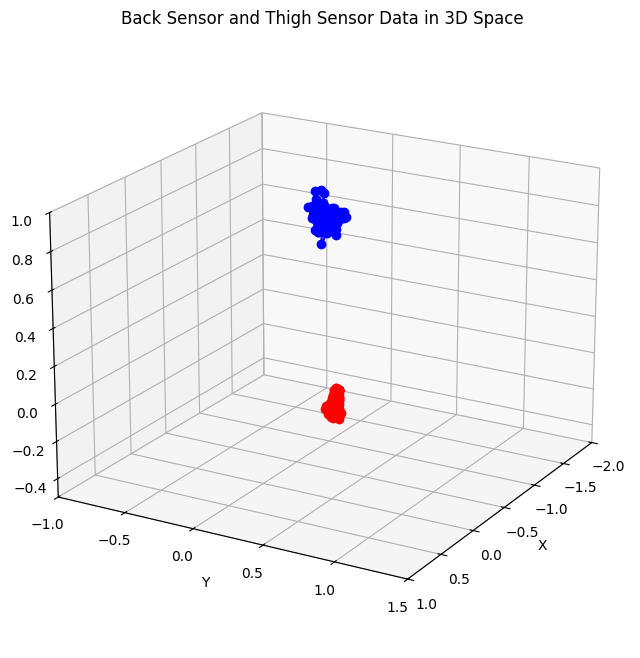

In [36]:
# 创建三维图  
fig = plt.figure(figsize=(10, 8))  
ax = fig.add_subplot(111, projection='3d')  

# 绘制 back_x, back_y, back_z 的三维散点图  
ax.plot(df.loc[25000:25500,'back_x'], df.loc[25000:25500,'back_y'], df.loc[25000:25500,'back_z'], c='r', marker='o')  
ax.plot(df.loc[25000:25500,'thigh_x'], df.loc[25000:25500,'thigh_y'], df.loc[25000:25500,'thigh_z'], c='b', marker='o')
# 添加标签和标题  
ax.set_title('Back Sensor and Thigh Sensor Data in 3D Space')  
ax.set_xlabel('X')  
ax.set_ylabel('Y')  
ax.set_zlabel('Z')  
# 设置坐标轴范围为正方向  
ax.set_xlim(-2, 1)  # 调整到最大值 (替换为你想要的范围)  
ax.set_ylim(-1, 1.5)  # 调整到最大值   
ax.set_zlim(-0.5, 1)  # 调整到最大值


# Optional: 设置视角  
ax.view_init(elev=20., azim=30)  # 设定合适的视点，可以根据需要调整  
plt.savefig("../figures/sit.jpg")

2. 绘制全数据集的运动类型分布情况，读取22个人的数据

In [39]:
path_all = "../harth_all/*.csv"  # 更新为实际路径  
data = data_process(path_all)

文件: ../harth_all\S006.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth_all\S008.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth_all\S009.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth_all\S010.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth_all\S012.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth_all\S013.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth_all\S014.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth_all\S015.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth_all\S016.csv, 列名: ['timestamp', 'back_x', 'back_y',

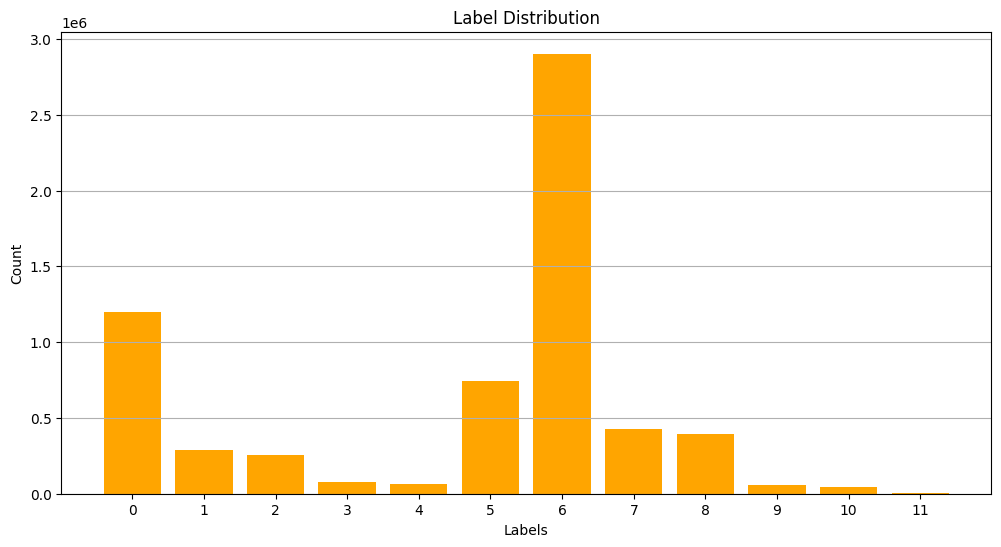

In [17]:
X = data.drop(columns=['timestamp', 'label']).values  
y = data['label'].values  

# 计算标签的分布  
label_counts = pd.Series(y).value_counts().sort_index()  # 确保按标签值排序  

# 确定想要的标签顺序  
desired_order = sorted(label_counts.index)  # 获取标签的sorted列表（确保是升序）  

# 绘制标签分布图  
plt.figure(figsize=(12, 6))  
plt.bar(desired_order, label_counts[desired_order], color='orange')  # 使用制定的顺序绘制条形图  
plt.title('Label Distribution')  
plt.xlabel('Labels')  
plt.ylabel('Count')  
plt.xticks(ticks=desired_order, labels=desired_order)  # 手动设置x轴刻度为desired_order  
plt.grid(axis='y')  

# 保存图像到文件  
plt.savefig("../figures/label_distribution.jpg")  # 保存图像  
plt.show()  # 再显示图形

In [19]:
path_all = "../harth/*.csv"  # 更新为实际路径  
data = data_process(path_all)
# 抽取三分之一的样本  
n = len(data["back_x"])
sample_size = n // 3  
data = data.sample(n=sample_size, random_state=2024)
data.info

文件: ../harth\S006.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth\S006.csv, 时间范围: ('2019-01-12 00:00:00', '2019-01-12 01:09:32')
原始数据标签: {1, 130, 3, 4, 5, 6, 7, 8, 13, 14}
新的数据标签: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
<bound method DataFrame.info of                      timestamp    back_x    back_y    back_z   thigh_x  \
0      2019-01-12 00:00:00.000 -0.760242  0.299570  0.468570 -5.092732   
1      2019-01-12 00:00:00.010 -0.530138  0.281880  0.319987  0.900547   
2      2019-01-12 00:00:00.020 -1.170922  0.186353 -0.167010 -0.035442   
3      2019-01-12 00:00:00.030 -0.648772  0.016579 -0.054284 -1.554248   
4      2019-01-12 00:00:00.040 -0.355071 -0.051831 -0.113419 -0.547471   
...                        ...       ...       ...       ...       ...   
408704 2019-01-12 01:09:32.880 -0.690417  0.035710 -0.697054  0.228261   
408705 2019-01-12 01:09:32.890 -0.745270  0.032438 -0.681320 -0.121986   
408706 2019-01-12 01:09:32.900 

<bound method DataFrame.info of                      timestamp    back_x    back_y    back_z   thigh_x  \
10490  2019-01-12 00:01:46.560 -0.984568  0.142520  0.052856 -0.973923   
256328 2019-01-12 00:43:44.640 -0.984992 -0.109124  0.050185 -0.982286   
340988 2019-01-12 00:58:06.000 -0.881127  0.264135  0.264181  0.205105   
160957 2019-01-12 00:27:46.000 -0.478163  0.000532 -0.873213  0.052054   
63678  2019-01-12 00:10:50.280 -0.952907  0.065564 -0.293759 -0.293596   
...                        ...       ...       ...       ...       ...   
253551 2019-01-12 00:43:12.980 -0.984512  0.129632 -0.007972  0.147391   
120302 2019-01-12 00:20:18.760 -0.982319  0.096712  0.020621 -0.973843   
139452 2019-01-12 00:23:43.430 -0.998903  0.097472  0.048370 -0.989865   
147228 2019-01-12 00:25:01.190 -0.967191 -0.097120  0.048772 -0.971921   
264216 2019-01-12 00:45:05.380 -0.257601 -0.849451 -0.443295  0.195124   

         thigh_y   thigh_z  label  
10490   0.046229 -0.226257      4  
256328 

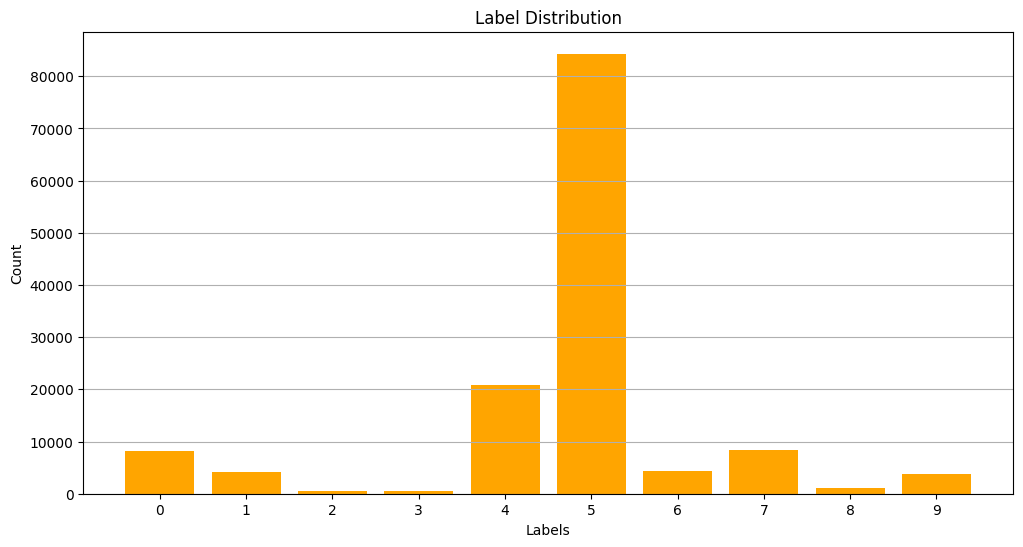

In [21]:
X = data.drop(columns=['timestamp', 'label']).values  
y = data['label'].values  

# 计算标签的分布  
label_counts = pd.Series(y).value_counts().sort_index()  # 确保按标签值排序  

# 确定想要的标签顺序  
desired_order = sorted(label_counts.index)  # 获取标签的sorted列表（确保是升序）  

# 绘制标签分布图  
plt.figure(figsize=(12, 6))  
plt.bar(desired_order, label_counts[desired_order], color='orange')  # 使用制定的顺序绘制条形图  
plt.title('Label Distribution')  
plt.xlabel('Labels')  
plt.ylabel('Count')  
plt.xticks(ticks=desired_order, labels=desired_order)  # 手动设置x轴刻度为desired_order  
plt.grid(axis='y')  

# 保存图像到文件  
plt.savefig("../figures/label_distribution_S006_1_3.jpg")  # 保存图像  
plt.show()  # 再显示图形

3. 绘制传感器位置坐标和标签随时间变化趋势图，读取S006.csv的全部数据

In [23]:
path = "../harth/*.csv"
df = data_process(path)

文件: ../harth\S006.csv, 列名: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
文件: ../harth\S006.csv, 时间范围: ('2019-01-12 00:00:00', '2019-01-12 01:09:32')
原始数据标签: {1, 130, 3, 4, 5, 6, 7, 8, 13, 14}
新的数据标签: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
<bound method DataFrame.info of                      timestamp    back_x    back_y    back_z   thigh_x  \
0      2019-01-12 00:00:00.000 -0.760242  0.299570  0.468570 -5.092732   
1      2019-01-12 00:00:00.010 -0.530138  0.281880  0.319987  0.900547   
2      2019-01-12 00:00:00.020 -1.170922  0.186353 -0.167010 -0.035442   
3      2019-01-12 00:00:00.030 -0.648772  0.016579 -0.054284 -1.554248   
4      2019-01-12 00:00:00.040 -0.355071 -0.051831 -0.113419 -0.547471   
...                        ...       ...       ...       ...       ...   
408704 2019-01-12 01:09:32.880 -0.690417  0.035710 -0.697054  0.228261   
408705 2019-01-12 01:09:32.890 -0.745270  0.032438 -0.681320 -0.121986   
408706 2019-01-12 01:09:32.900 

- 背部传感器

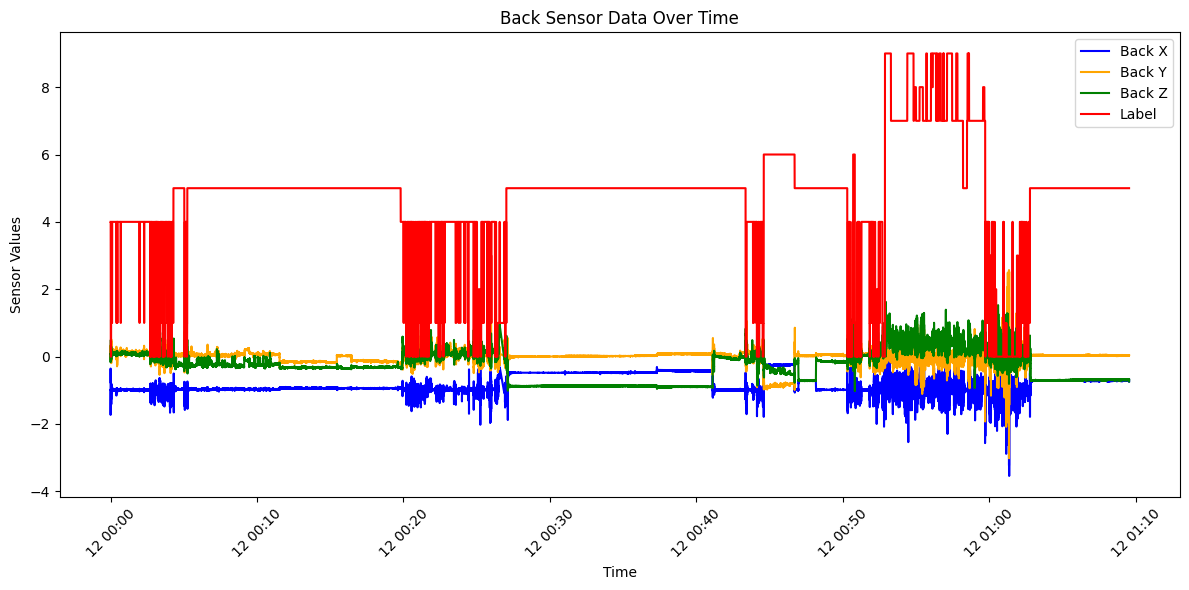

In [25]:
# 将时间戳转换为datetime格式  
df['timestamp'] = pd.to_datetime(df['timestamp'])  

# 设置图形大小  
plt.figure(figsize=(12, 6))  

# 绘制 back_x, back_y, back_z 随时间变化的图  
plt.plot(df['timestamp'], df['back_x'], label='Back X', color='blue')  
plt.plot(df['timestamp'], df['back_y'], label='Back Y', color='orange')  
plt.plot(df['timestamp'], df['back_z'], label='Back Z', color='green')  
plt.plot(df['timestamp'], df['label'], label='Label', color='red') 

# 添加标题和标签  
plt.title('Back Sensor Data Over Time')  
plt.xlabel('Time')  
plt.ylabel('Sensor Values')  
plt.legend()  

# 显示图形  
plt.xticks(rotation=45)  # 旋转x轴标签以便更好地显示  
plt.tight_layout()  # 自动调整布局  
plt.savefig("../figures/back_time.jpg")
plt.show() 

- 大腿传感器

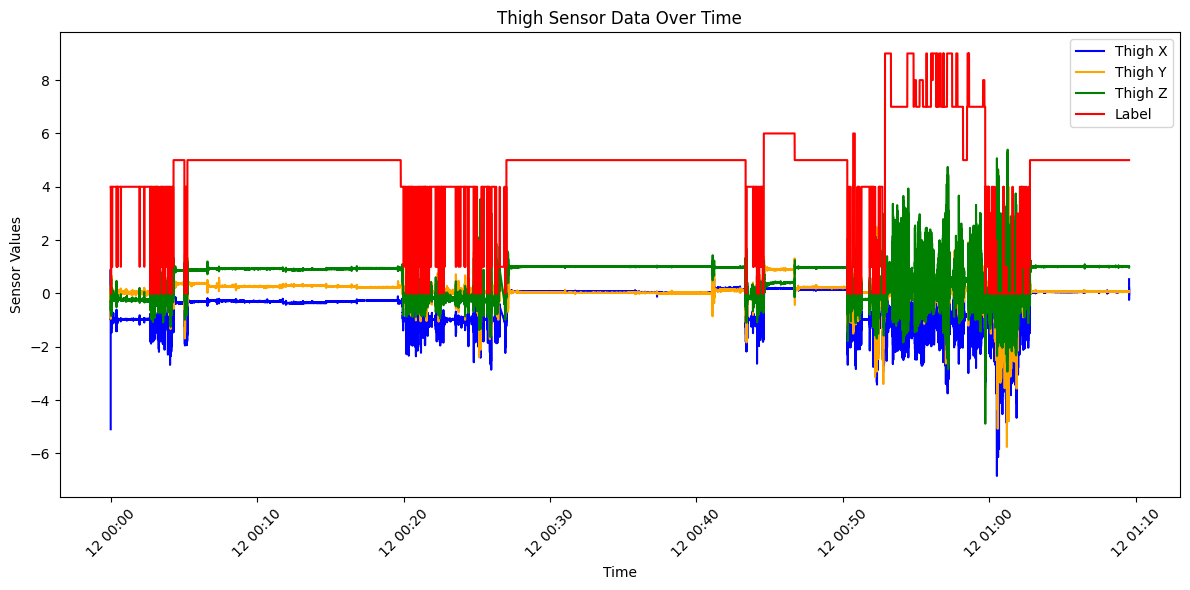

In [27]:
# 将时间戳转换为datetime格式  
df['timestamp'] = pd.to_datetime(df['timestamp'])  

# 设置图形大小  
plt.figure(figsize=(12, 6))  

# 绘制 thigh_x, thigh_y, thigh_z 随时间变化的图  
plt.plot(df['timestamp'], df['thigh_x'], label='Thigh X', color='blue')  
plt.plot(df['timestamp'], df['thigh_y'], label='Thigh Y', color='orange')  
plt.plot(df['timestamp'], df['thigh_z'], label='Thigh Z', color='green')  
plt.plot(df['timestamp'], df['label'], label='Label', color='red') 

# 添加标题和标签  
plt.title('Thigh Sensor Data Over Time')  
plt.xlabel('Time')  
plt.ylabel('Sensor Values')  
plt.legend()  

# 显示图形  
plt.xticks(rotation=45)  # 旋转x轴标签以便更好地显示  
plt.tight_layout()  # 自动调整布局  
plt.savefig("../figures/thigh_time.jpg")
plt.show() 